In [1]:
import pandas as pd
import numpy as np
import mplfinance as mpf
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt
import statsmodels.api as sm
import yfinance
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [45,30]
plt.rc('font', size = 20)
import warnings
warnings.filterwarnings('ignore')

In [2]:
appl = pd.read_csv("/Users/kundaimariga/Downloads/AAPL.csv")

In [3]:
logappl = np.log(appl['Adj Close'])
logappl.diff()
rappl =100*(logappl.diff())
rappl = rappl.replace(np.nan, 0)

In [4]:
appl['return']= rappl

In [5]:
appl.set_index('Date')

,Open,High,Low,Close,Adj Close,Volume,return
Date,,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.562591,493729600,0.000000
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.573935,601904800,0.172709
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.469369,552160000,-1.603401
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.457407,477131200,-0.185073
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.500339,447610800,0.662649
...,...,...,...,...,...,...,...
2020-12-23,132.160004,132.429993,130.779999,130.960007,130.347565,88223700,-0.700047
2020-12-24,131.320007,133.460007,131.100006,131.970001,131.352829,54930100,0.768259
2020-12-28,133.990005,137.339996,133.509995,136.690002,136.050766,124486200,3.514104


In [6]:
appl = appl.astype({'Date': 'datetime64[ns]'})

# Check for autocorrlation and stationarity in adj close

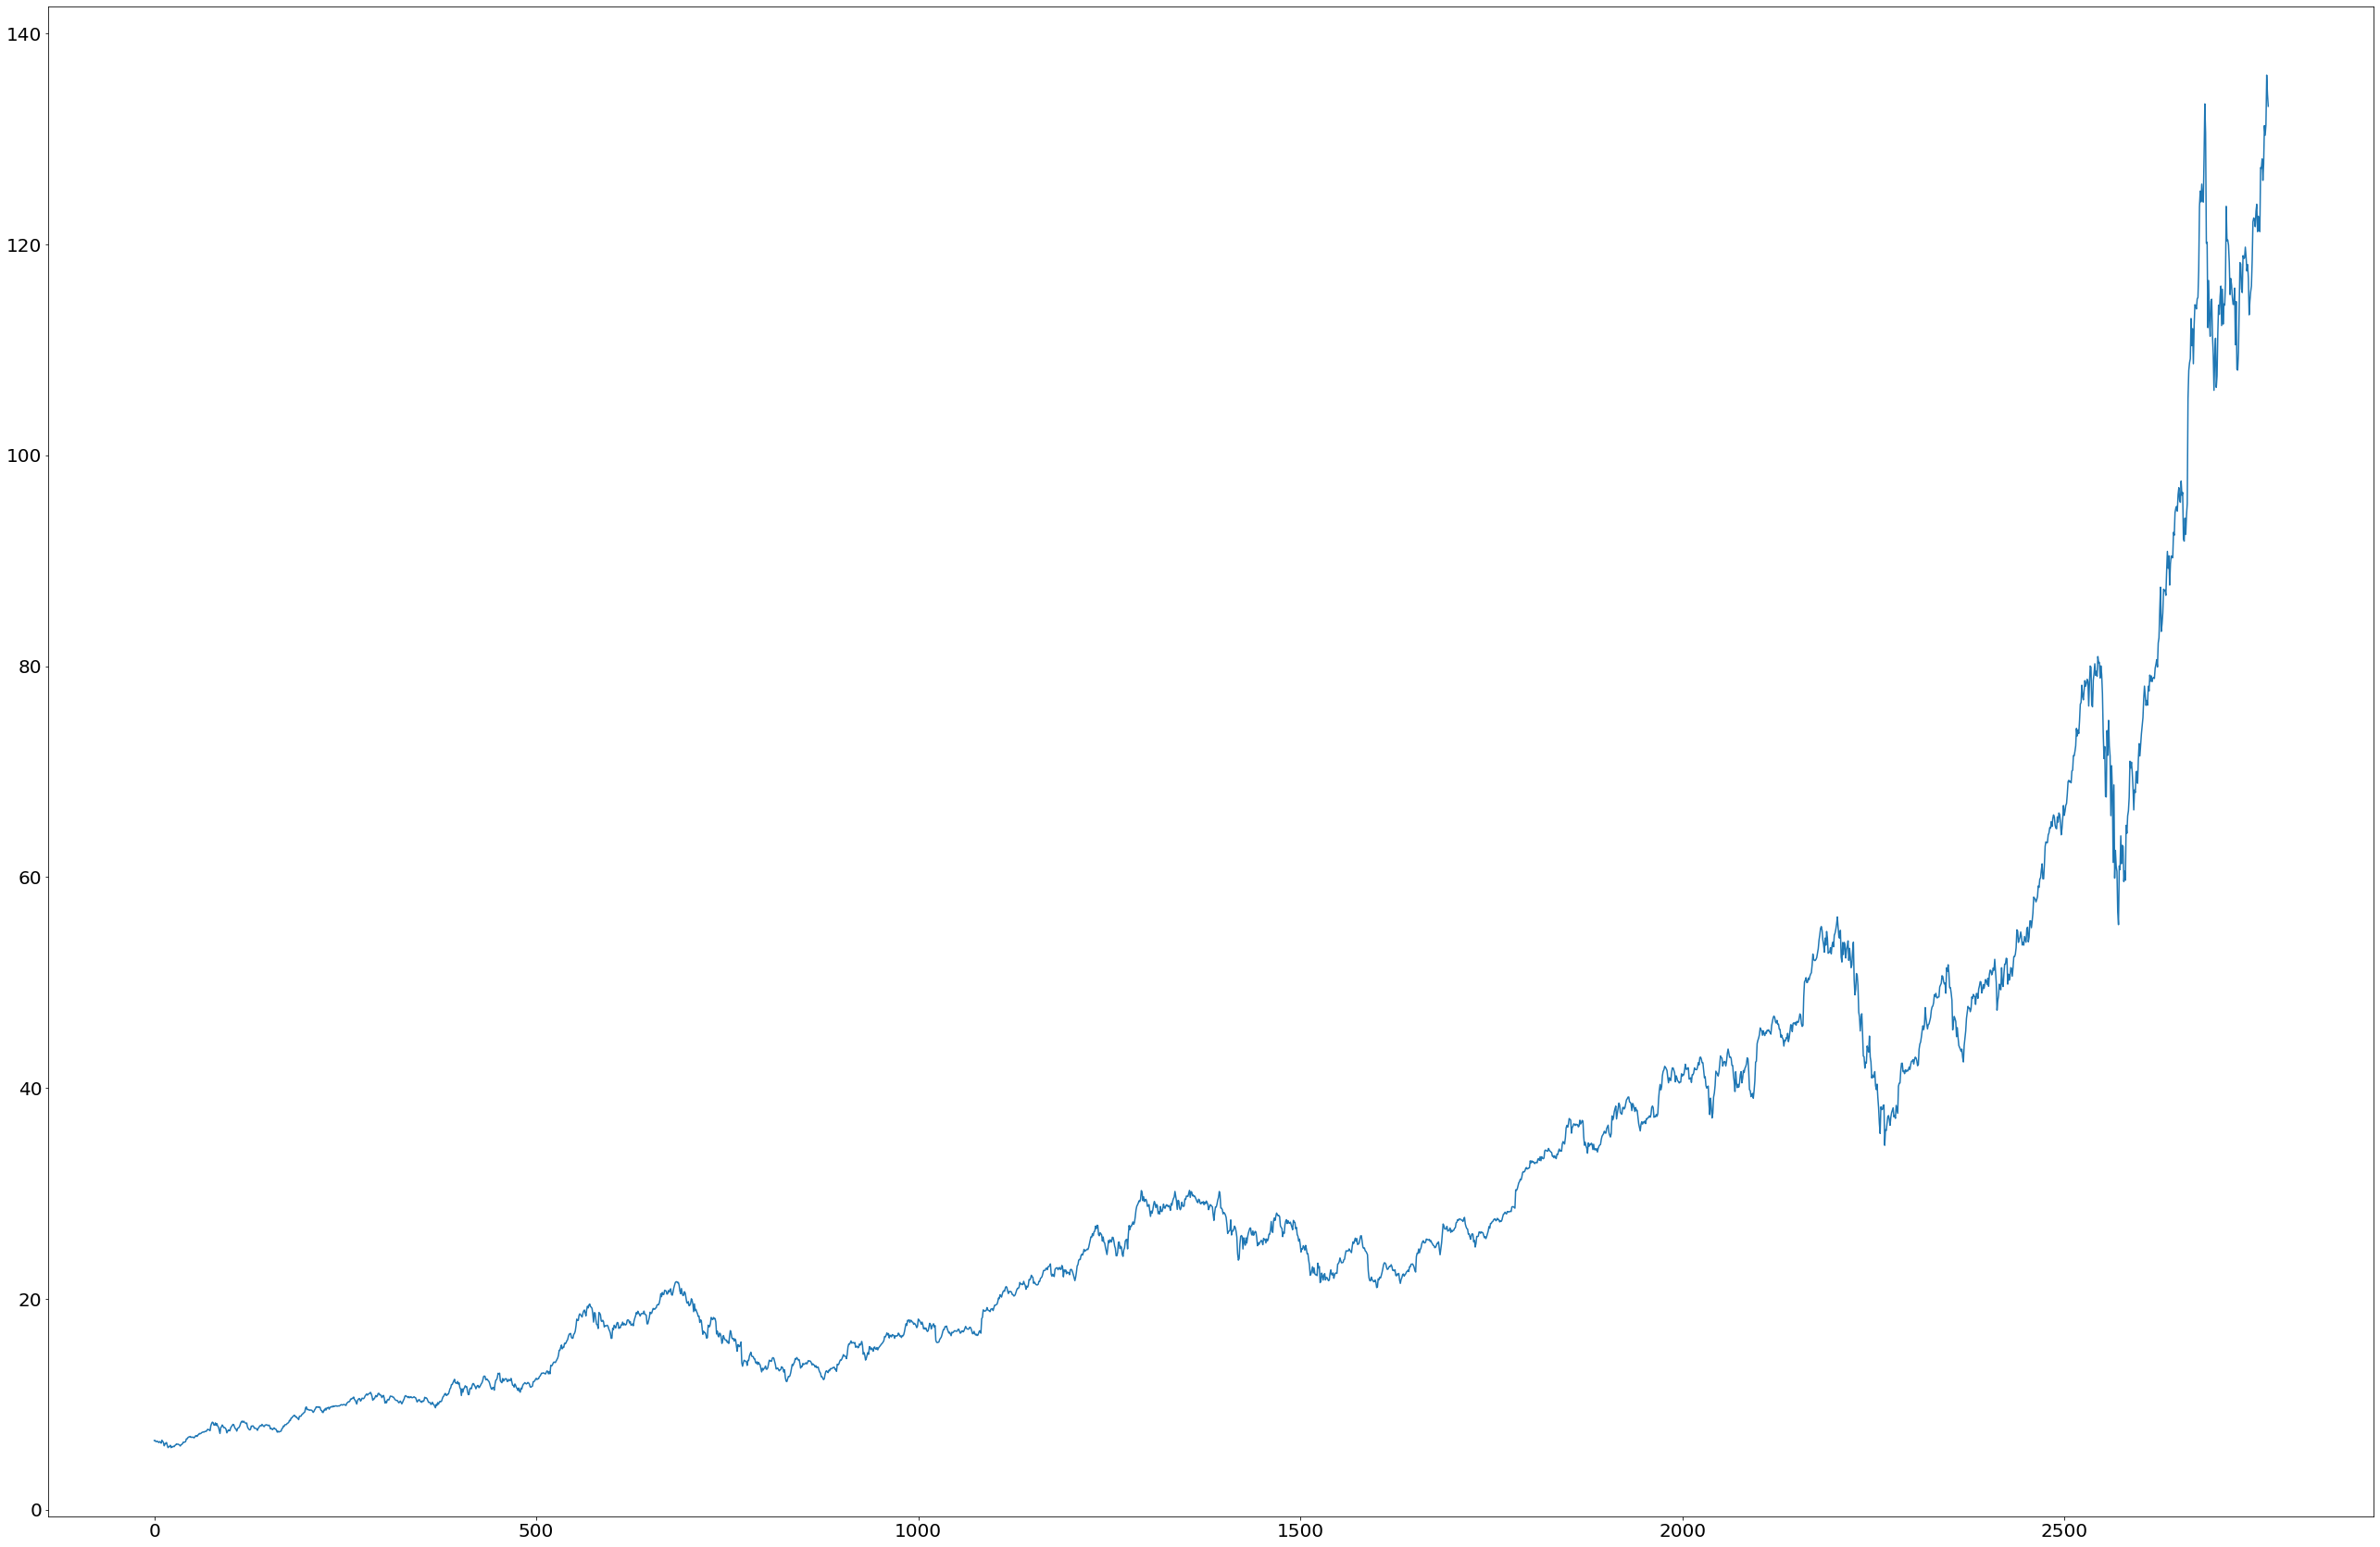

In [7]:
plt.plot(appl['Adj Close'])

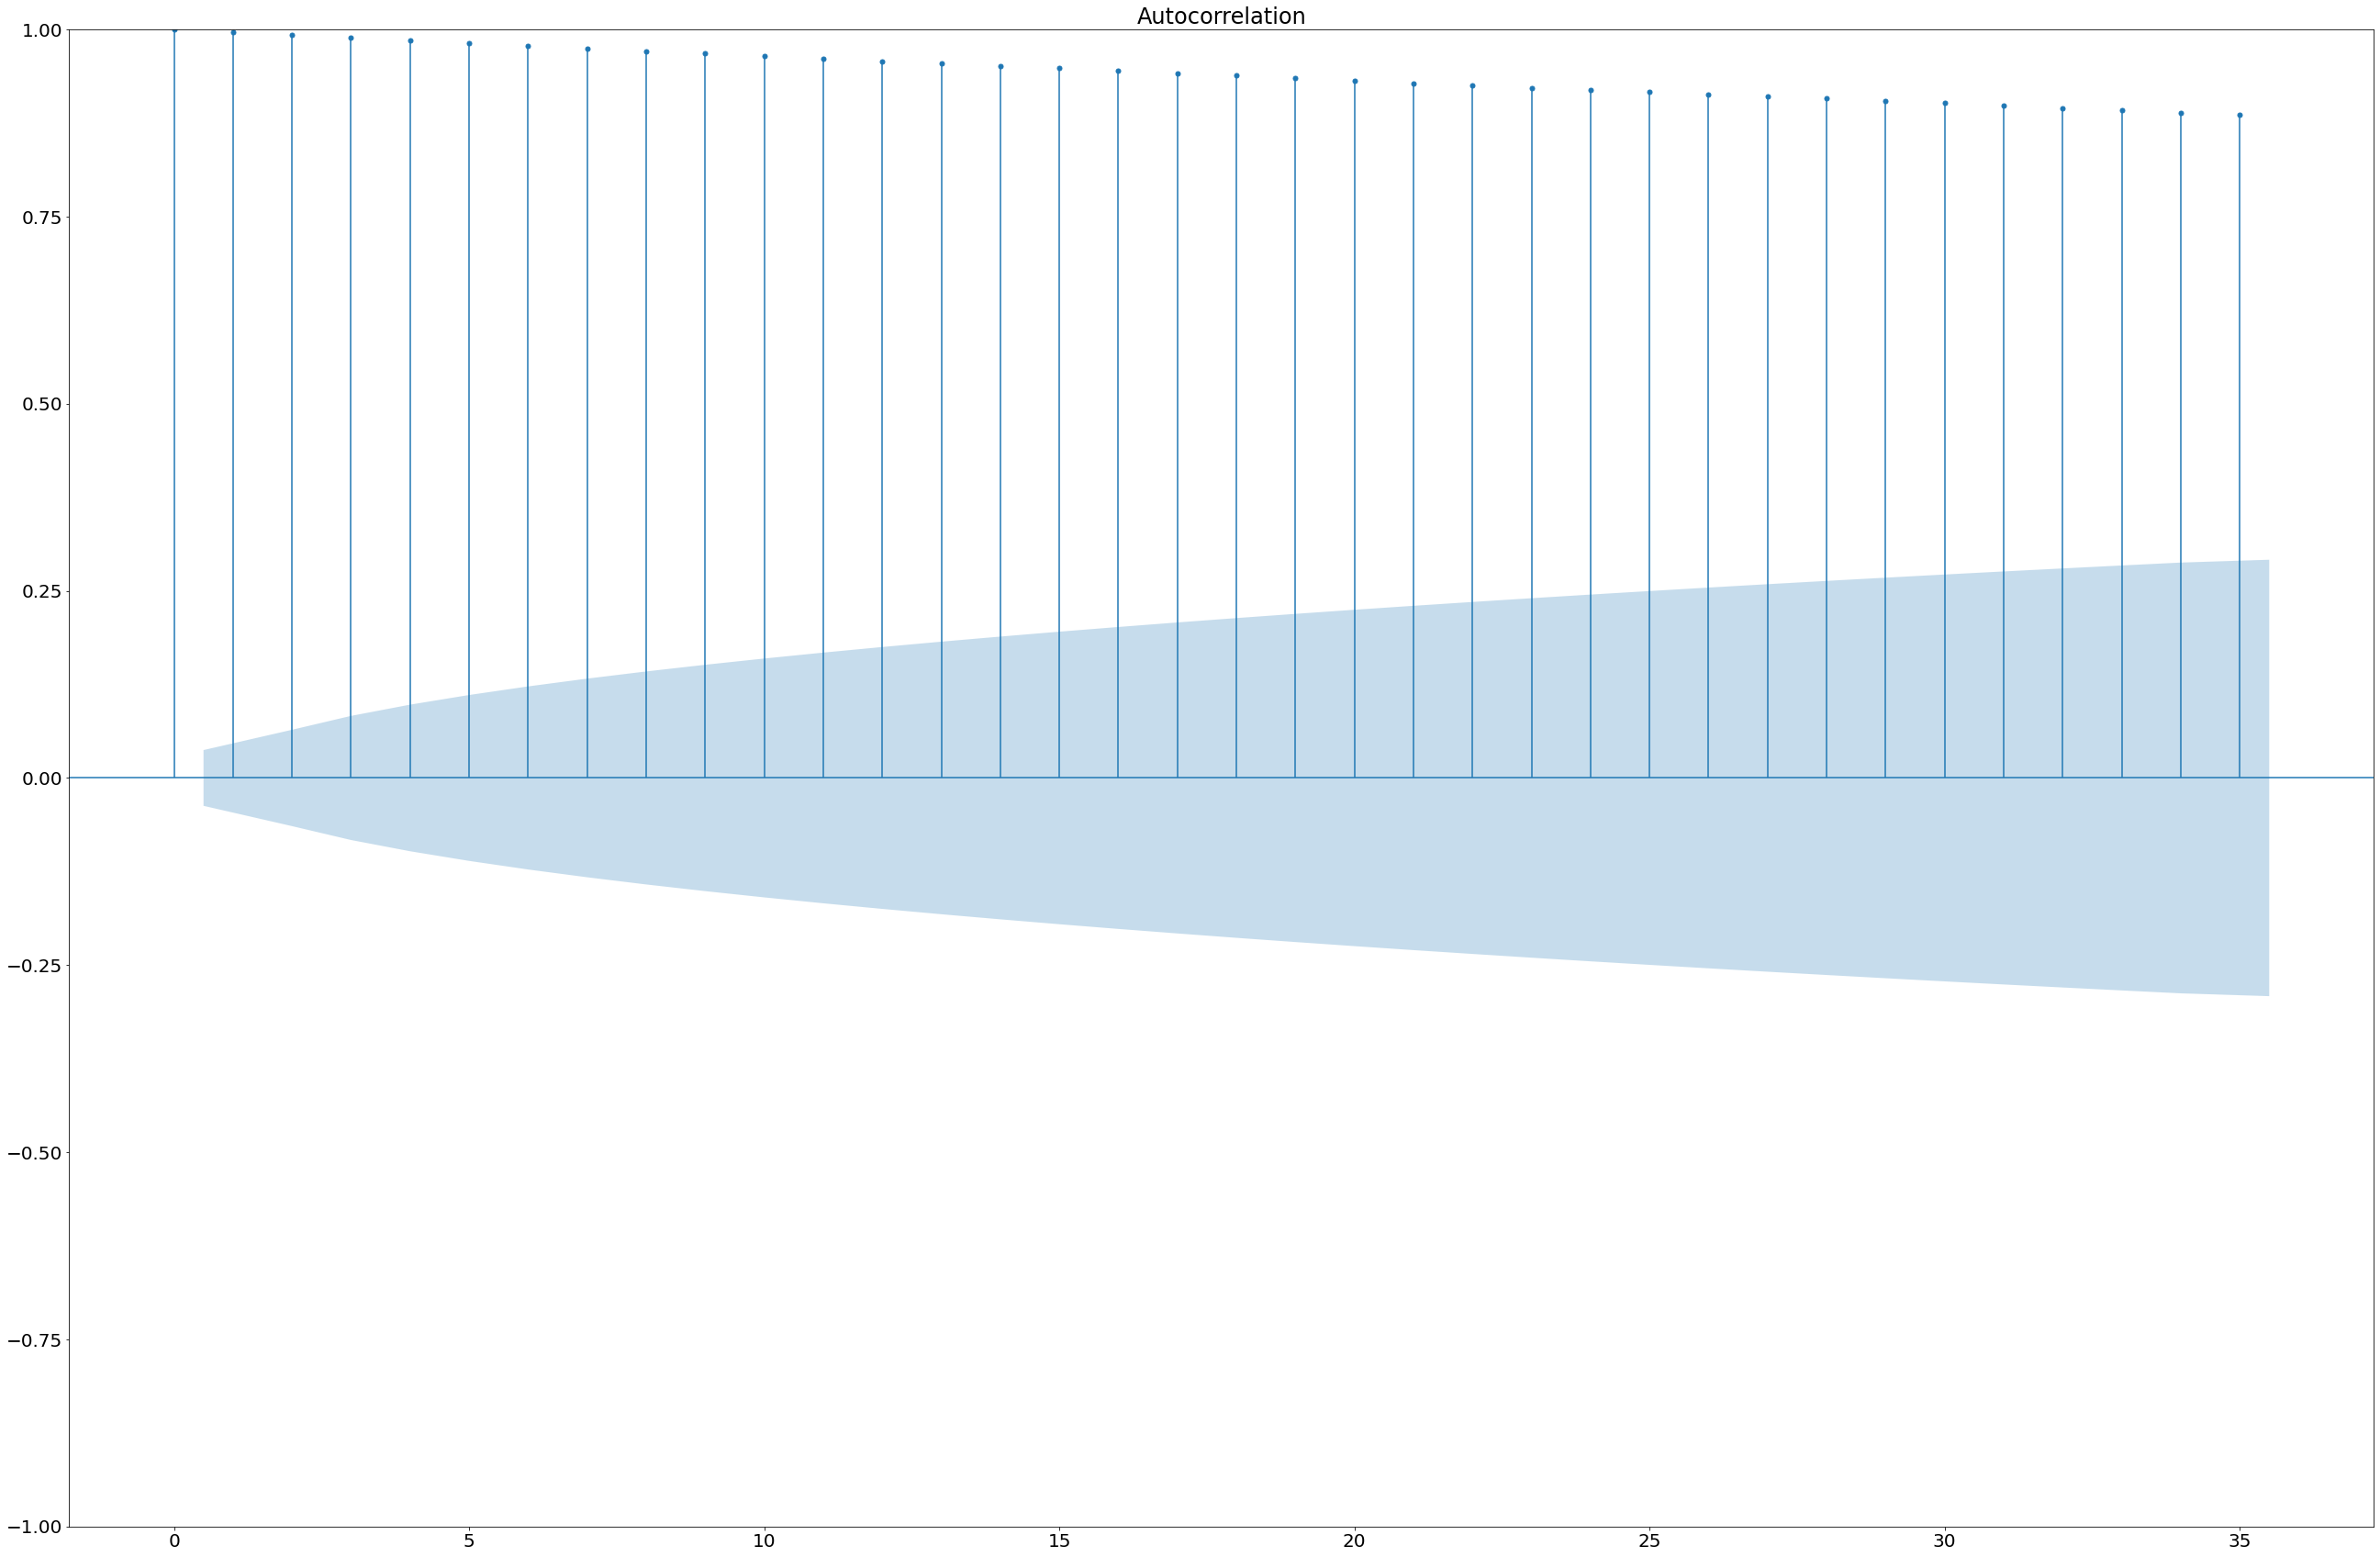

In [8]:
plot_acf(appl['Adj Close']);

In [9]:
#there is some serial correlation between returns.

In [10]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(appl['Adj Close'], autolag = 'AIC')
print("1. ADF: ", dftest[0])
print("2. P-value: ", dftest[1])
print("3. Num of Lags: ", dftest[2])
print("4. Num of Observations used for ADF Regression and Critical Values Calculations: ", dftest[3])
print("5. Critical Values: ")
for key, val in dftest[4].items():
    print("\t", key, val)

1. ADF:  3.5887938387619718
2. P-value:  1.0
3. Num of Lags:  28
4. Num of Observations used for ADF Regression and Critical Values Calculations:  2739
5. Critical Values: 
	 1% -3.4327397185476918
	 5% -2.8625958054606793
	 10% -2.5673320392686283


In [11]:
#the data is non-stationary

In [12]:
#load tweet polarity data
appltweets = pd.read_csv("/Users/kundaimariga/Downloads/AAPL-5.csv")

In [13]:
appltweets

,date,ts_polarity,twitter_volume
0,2016-01-01,0.119693,417
1,2016-01-02,0.140774,495
2,2016-01-03,0.181132,518
3,2016-01-04,0.070389,1133
4,2016-01-05,0.133635,1430
...,...,...,...
1336,2019-08-29,0.056460,1083
1337,2019-08-30,0.106096,1005
1338,2019-08-31,0.151625,224
1339,2019-09-01,0.059887,200


In [14]:
lagpol = appltweets['ts_polarity'].diff()

In [15]:
appltweets['lagpol'] = lagpol
appltweets

,date,ts_polarity,twitter_volume,lagpol
0,2016-01-01,0.119693,417,NaN
1,2016-01-02,0.140774,495,0.021082
2,2016-01-03,0.181132,518,0.040357
3,2016-01-04,0.070389,1133,-0.110743
4,2016-01-05,0.133635,1430,0.063246
...,...,...,...,...
1336,2019-08-29,0.056460,1083,-0.005017
1337,2019-08-30,0.106096,1005,0.049636
1338,2019-08-31,0.151625,224,0.045529
1339,2019-09-01,0.059887,200,-0.091738


In [16]:
#need to rename data column so that I can merge it with the stock data
appltweets = appltweets.rename(columns={'date': 'Date'})

In [17]:
appltweets = appltweets.astype({'Date': 'datetime64[ns]'})

In [18]:
#merge tweet data
applfull = pd.merge(appl, appltweets, on = 'Date')
applfull = applfull.astype({'Date': 'datetime64[ns]'})
applnew = applfull.set_index('Date')
applnew

,Open,High,Low,Close,Adj Close,Volume,return,ts_polarity,twitter_volume,lagpol
Date,,,,,,,,,,
2016-01-04,25.652500,26.342501,25.500000,26.337500,24.286833,270597600,0.085482,0.070389,1133,-0.110743
2016-01-05,26.437500,26.462500,25.602501,25.677500,23.678219,223164000,-2.537876,0.133635,1430,0.063246
2016-01-06,25.139999,25.592501,24.967501,25.174999,23.214844,273829600,-1.976369,0.072042,1949,-0.061593
2016-01-07,24.670000,25.032499,24.107500,24.112499,22.235069,324377600,-4.312117,0.074369,2289,0.002328
2016-01-08,24.637501,24.777500,24.190001,24.240000,22.352642,283192000,0.527380,0.051595,2235,-0.022775
...,...,...,...,...,...,...,...,...,...,...
2019-08-26,51.465000,51.797501,51.264999,51.622501,50.788677,104174400,1.882097,0.072340,888,-0.059446
2019-08-27,51.965000,52.137501,50.882500,51.040001,50.215584,103493200,-1.134802,0.117541,962,0.045201
2019-08-28,51.025002,51.430000,50.830002,51.382500,50.552551,63755200,0.668799,0.061477,895,-0.056065


In [19]:
applnew.index

DatetimeIndex(['2016-01-04', '2016-01-05', '2016-01-06', '2016-01-07',
               '2016-01-08', '2016-01-11', '2016-01-12', '2016-01-13',
               '2016-01-14', '2016-01-15',
               ...
               '2019-08-19', '2019-08-20', '2019-08-21', '2019-08-22',
               '2019-08-23', '2019-08-26', '2019-08-27', '2019-08-28',
               '2019-08-29', '2019-08-30'],
              dtype='datetime64[ns]', name='Date', length=922, freq=None)

In [20]:
#index the data by date
applnew['Date'] = pd.to_datetime(applnew.index)
applnew['Date'] = applnew['Date'].apply(mpl_dates.date2num)

applnew = applnew.loc[:,['Date', 'Adj Close','return','Volume', 'ts_polarity', 'lagpol', 'twitter_volume']]
appl = applnew

In [21]:
appl = appl.replace(np.nan, 0)

In [22]:
appl

,Date,Adj Close,return,Volume,ts_polarity,lagpol,twitter_volume
Date,,,,,,,
2016-01-04,16804.0,24.286833,0.085482,270597600,0.070389,-0.110743,1133
2016-01-05,16805.0,23.678219,-2.537876,223164000,0.133635,0.063246,1430
2016-01-06,16806.0,23.214844,-1.976369,273829600,0.072042,-0.061593,1949
2016-01-07,16807.0,22.235069,-4.312117,324377600,0.074369,0.002328,2289
2016-01-08,16808.0,22.352642,0.527380,283192000,0.051595,-0.022775,2235
...,...,...,...,...,...,...,...
2019-08-26,18134.0,50.788677,1.882097,104174400,0.072340,-0.059446,888
2019-08-27,18135.0,50.215584,-1.134802,103493200,0.117541,0.045201,962
2019-08-28,18136.0,50.552551,0.668799,63755200,0.061477,-0.056065,895


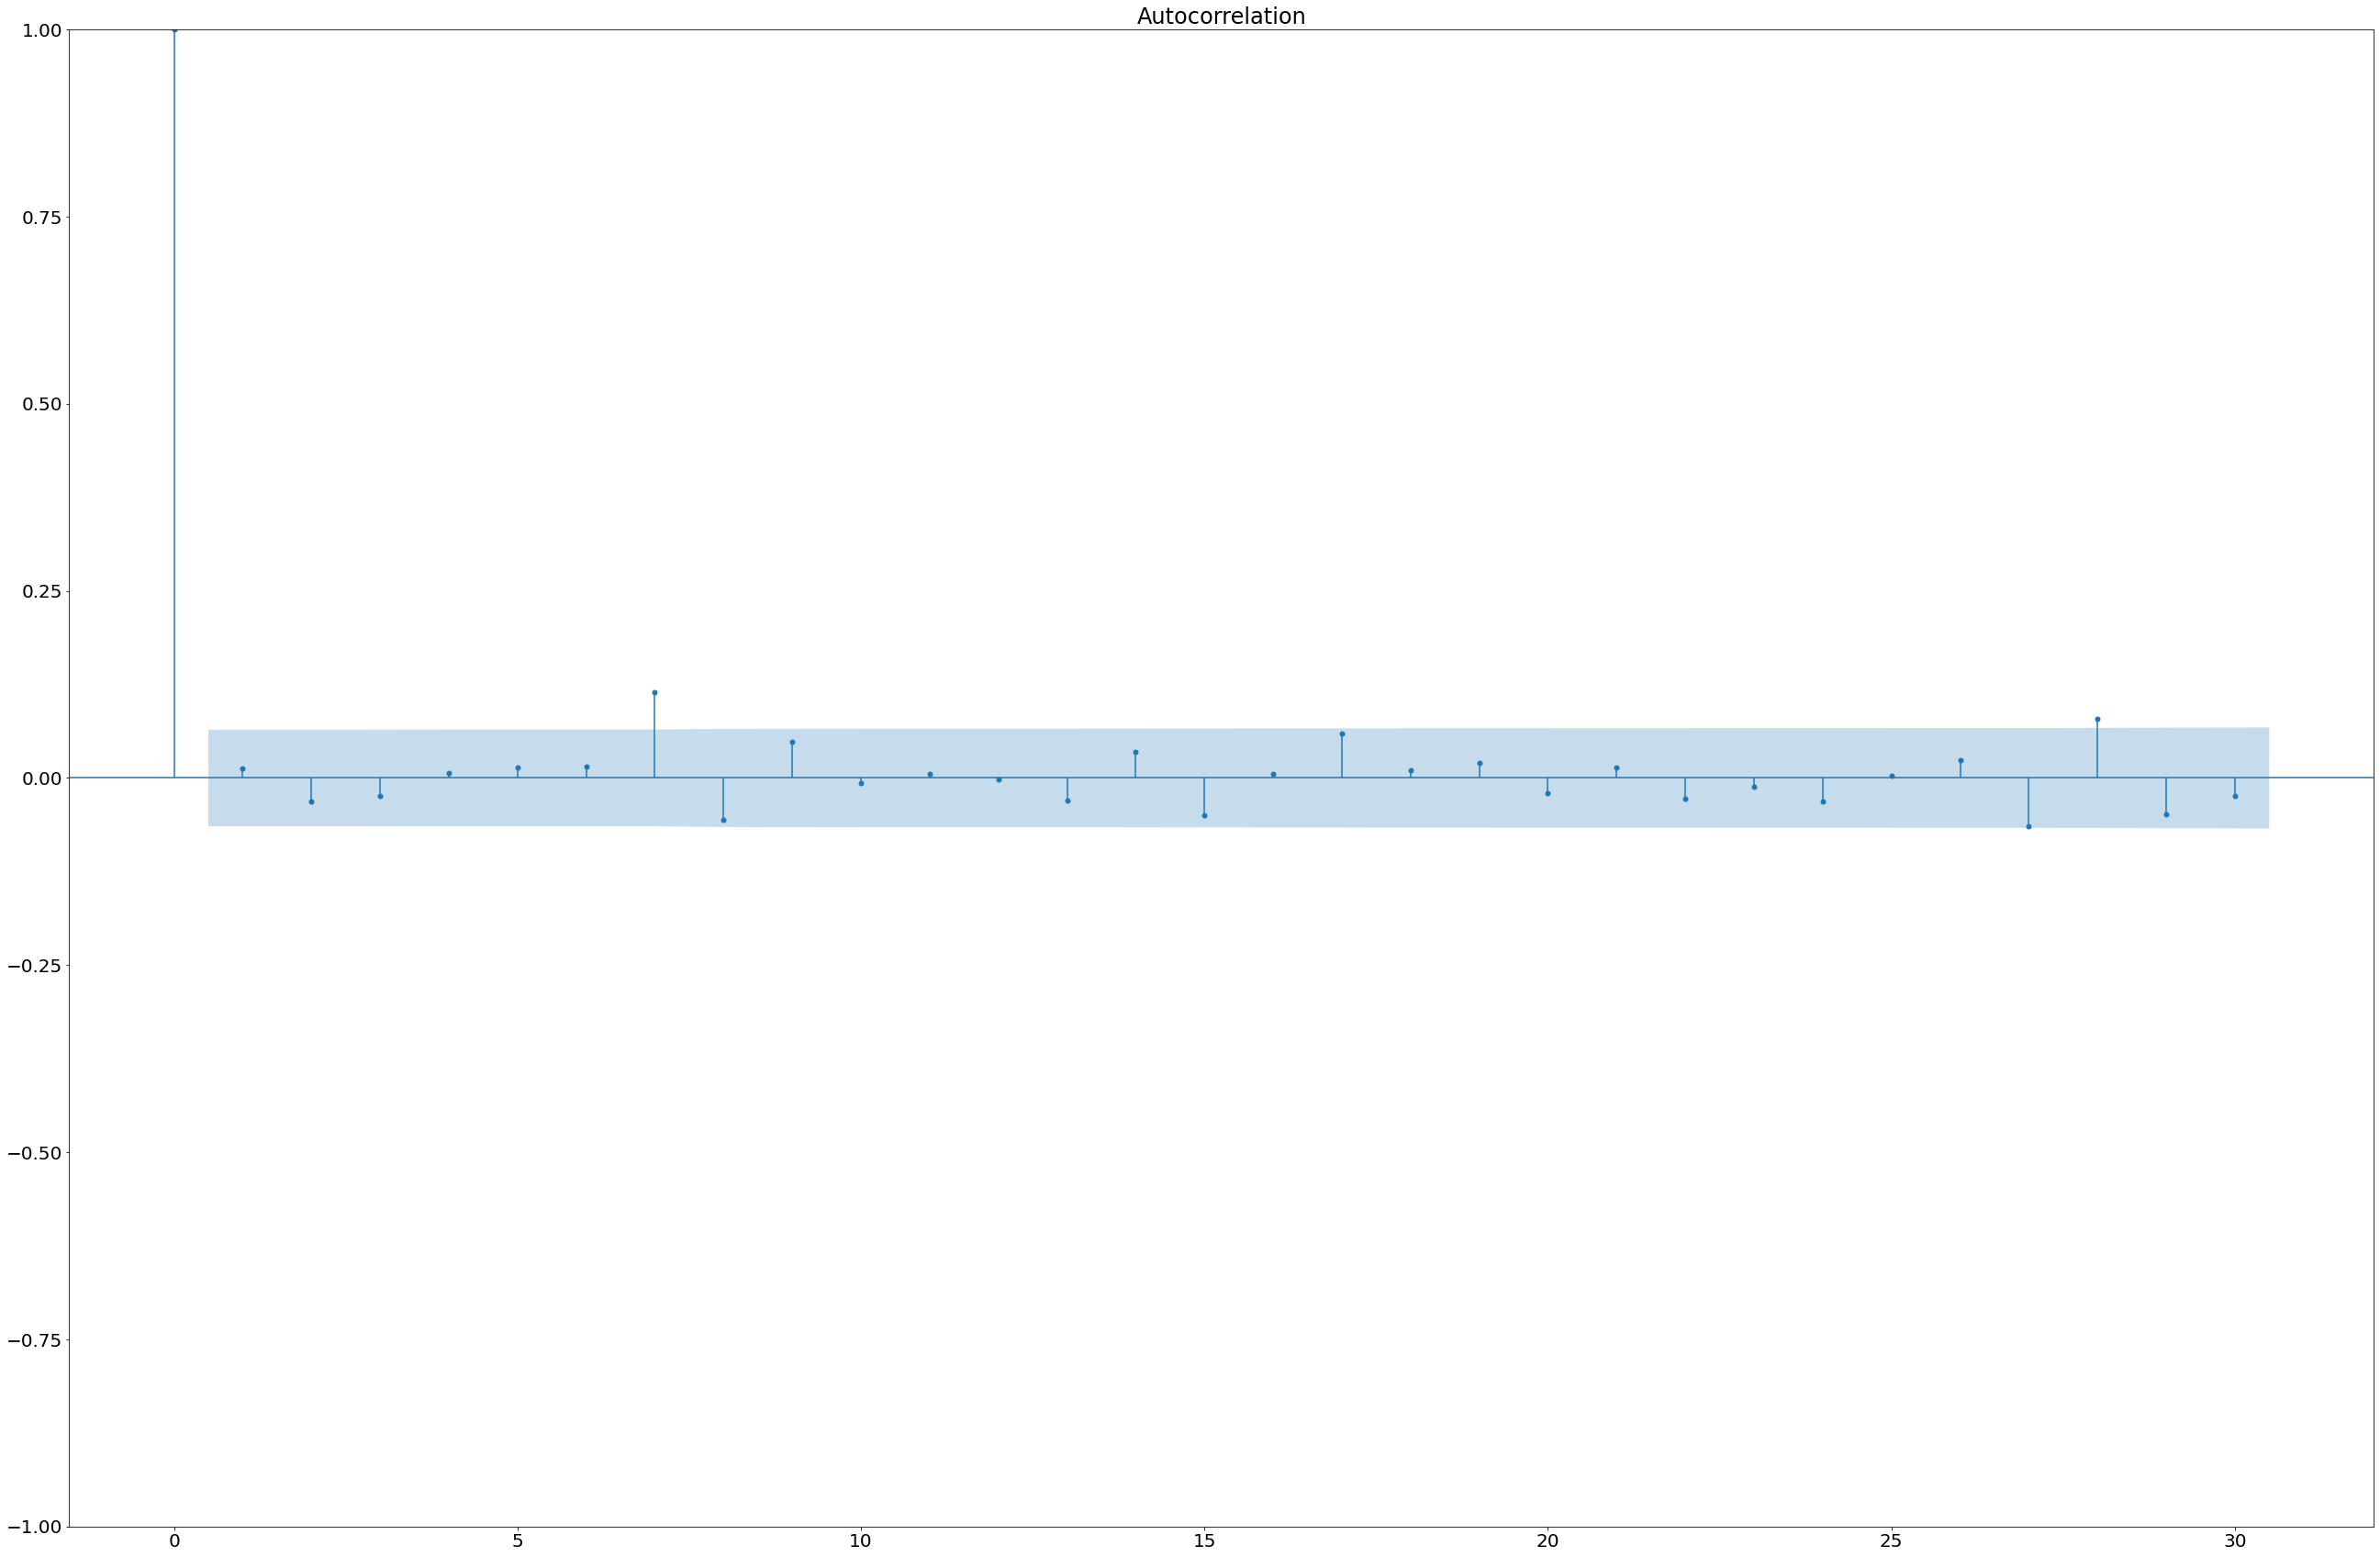

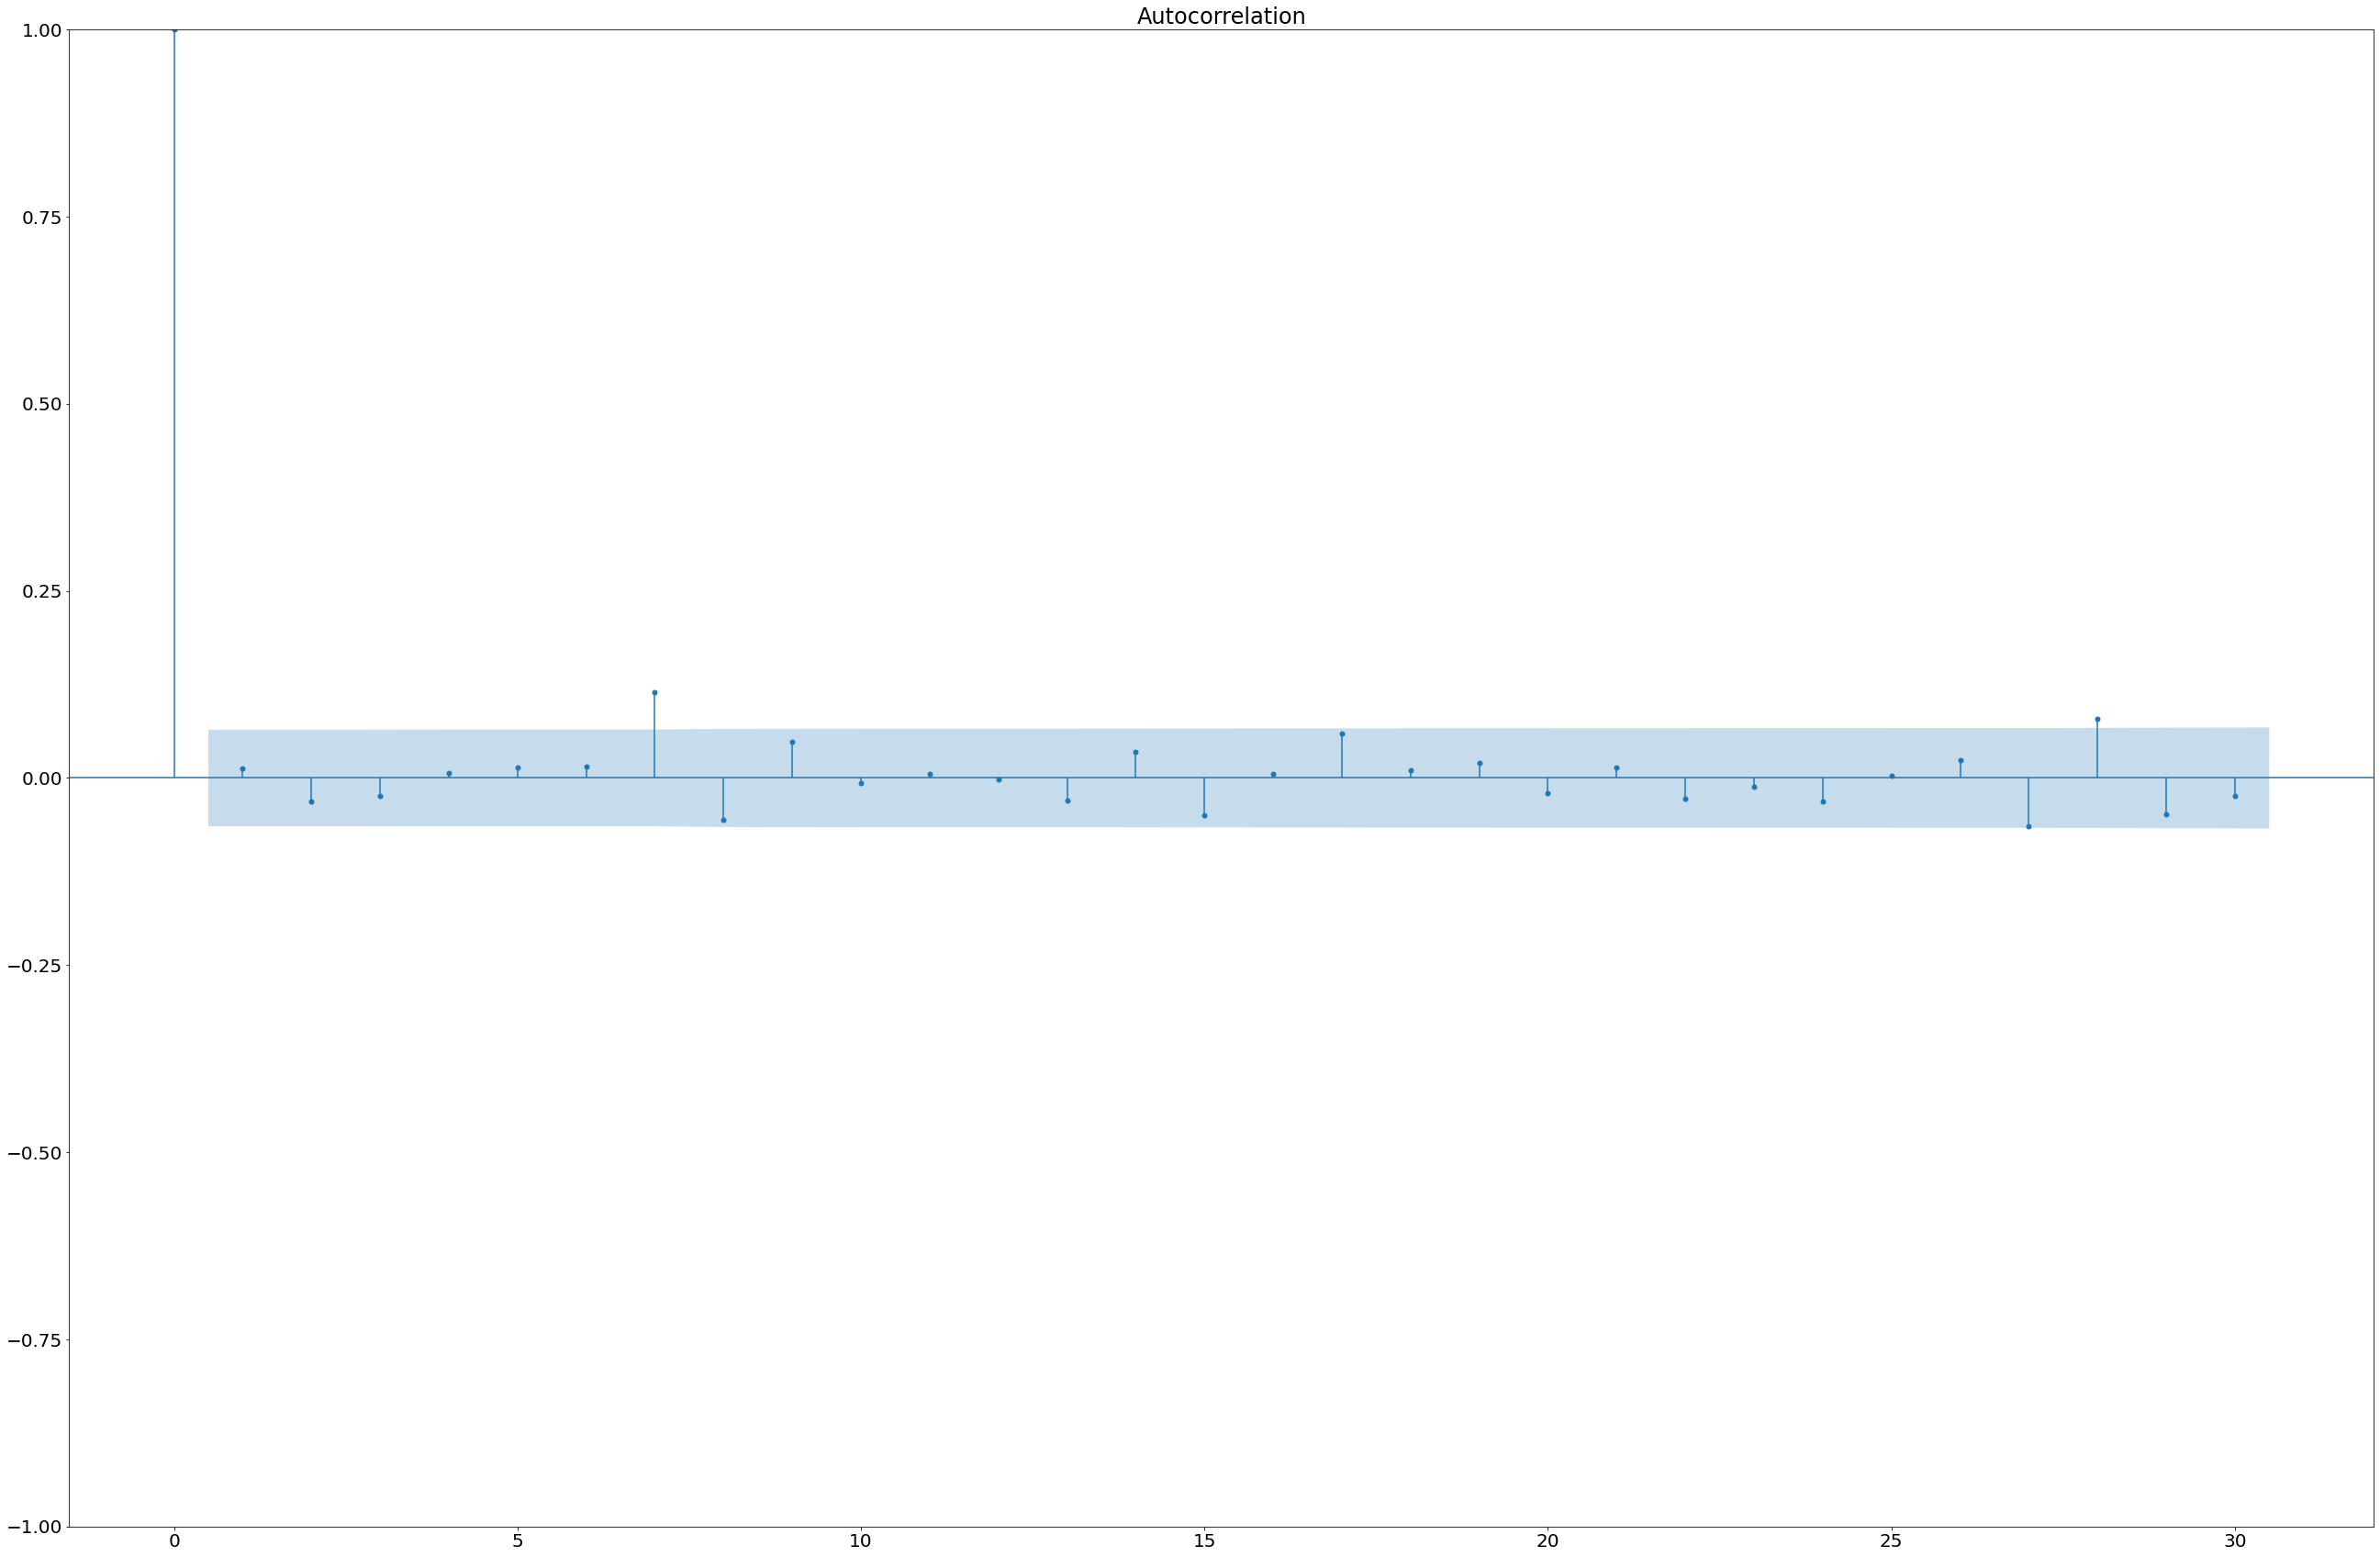

In [23]:
plot_acf(appl['return'])

# Data visualization

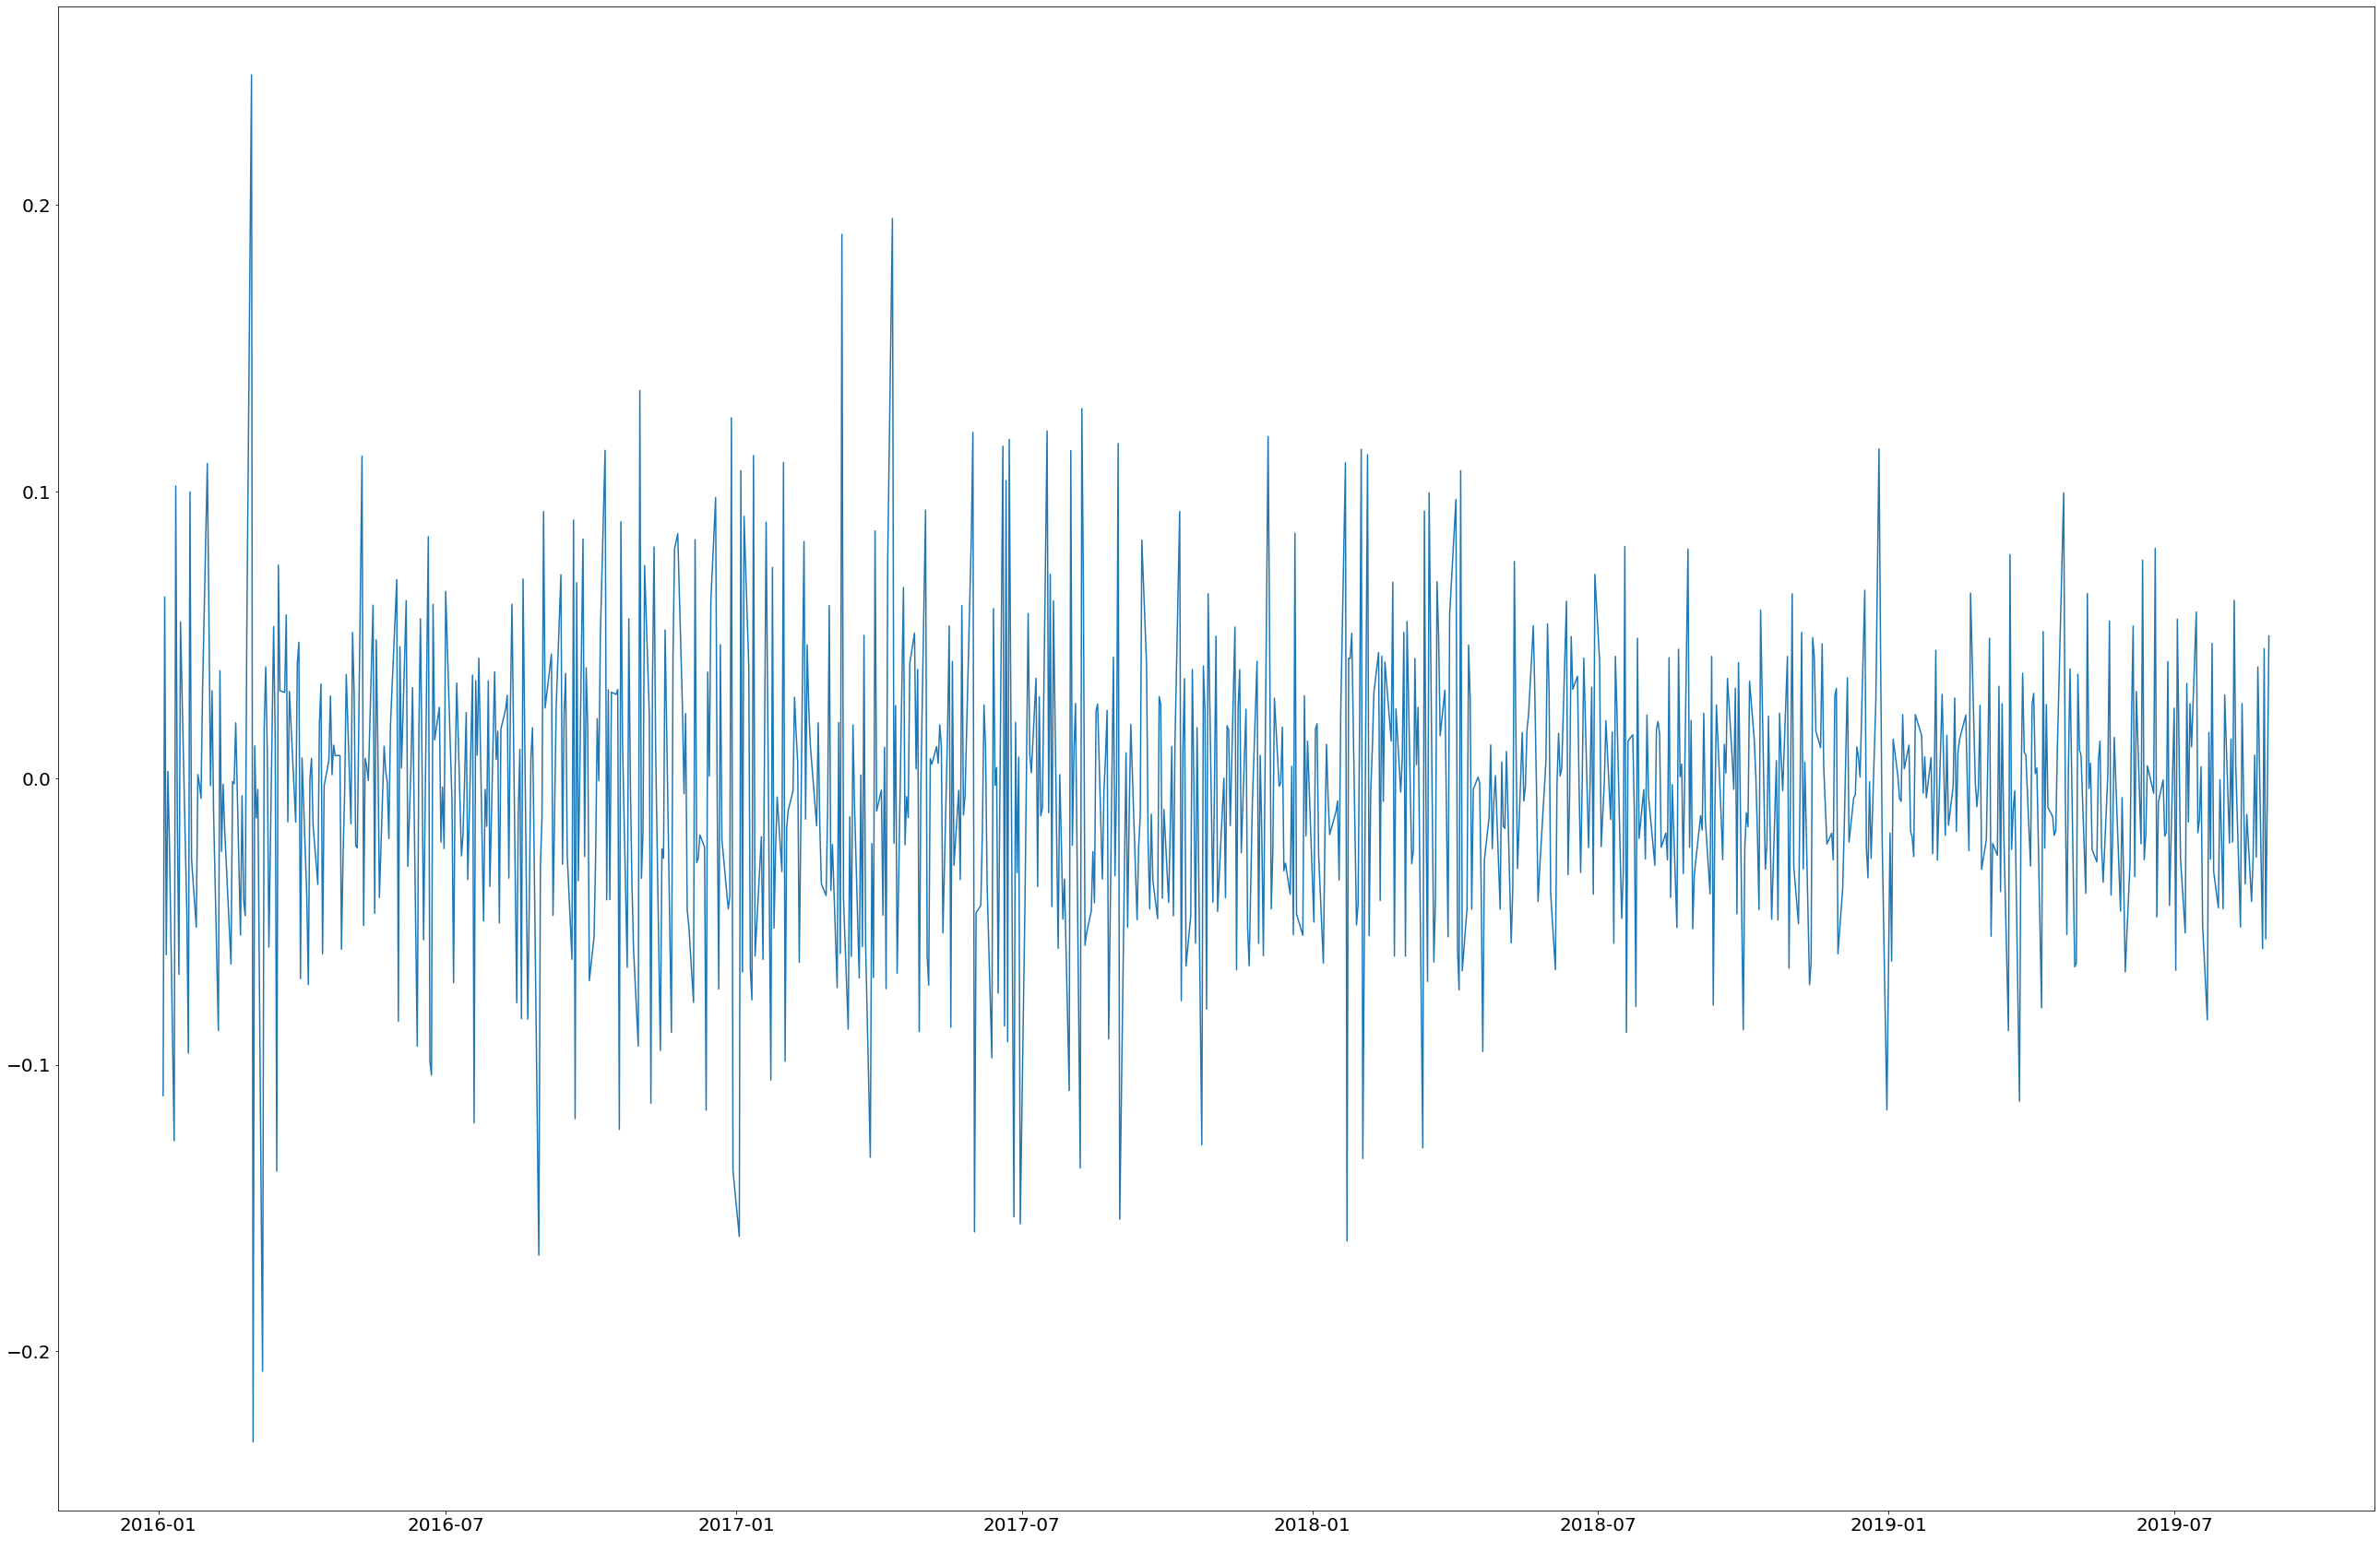

In [24]:
plt.plot(appl['lagpol'])

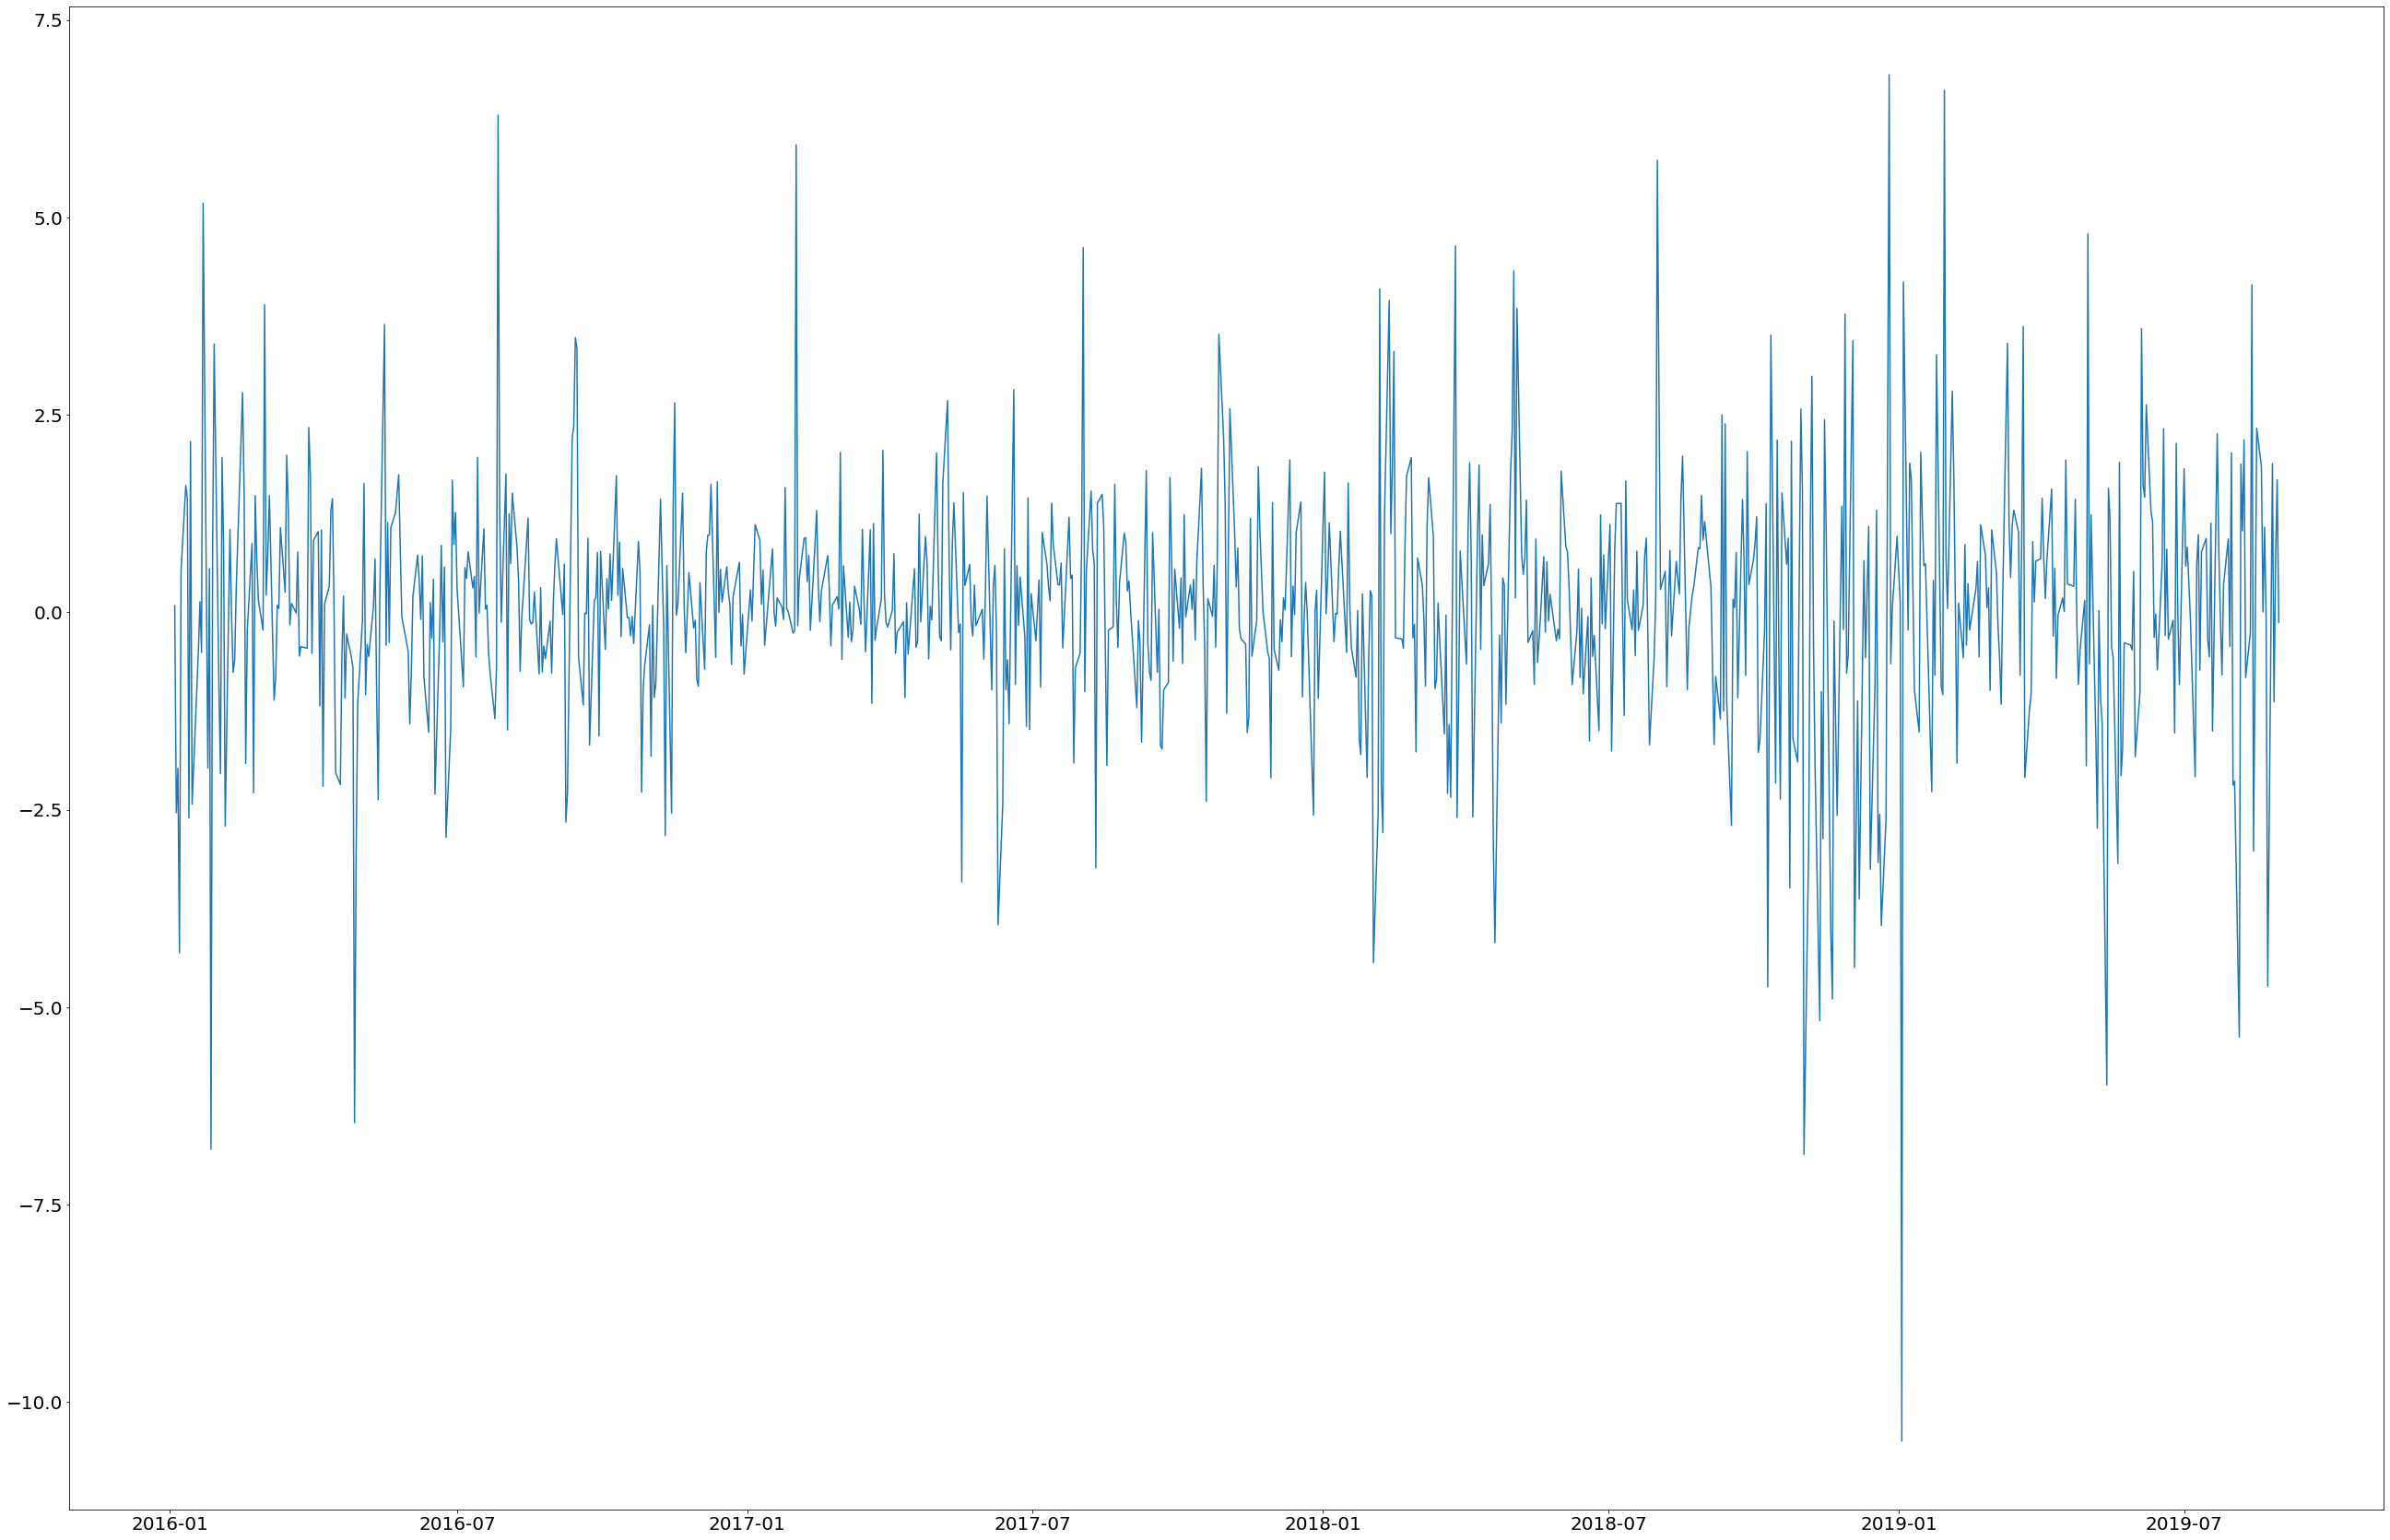

In [25]:
plt.plot(appl['return'])

# Check for ideal model

In [26]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings('ignore')

In [27]:
ideal_fit = auto_arima(appl['Adj Close'], trace=True, supress_warnings=True)
ideal_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1730.073, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1732.072, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1732.072, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1730.154, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1733.790, Time=0.26 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.912 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  922
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -863.037
Date:                Thu, 09 Dec 2021   AIC                           1730.073
Time:                        14:09:24   BIC                           1739.724
Sample:                             0   HQIC                          1733.756
                                - 922                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0294      0.021      1.410      0.159      -0.011       0.070
sigma2         0.3815      0.009     41.332      0.000       0.363       0.400
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1334.82
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               6.61   Skew:                            -0.60
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [28]:
#the model described above assumes that a model with just white noise is ideal. Looking at the plots for my data
#I dont believe this to be true due to the volatility shown 

# MODEL 1 - ARIMAX model order (0,1,0)

In [29]:
print(appl.shape)
train = appl.iloc[:-30]
test = appl.iloc[-30:]
print(train.shape, test.shape)

(922, 7)
(892, 7) (30, 7)


In [30]:
train.dtypes

Date              float64
Adj Close         float64
return            float64
Volume              int64
ts_polarity       float64
lagpol            float64
twitter_volume      int64
dtype: object

In [31]:
train

,Date,Adj Close,return,Volume,ts_polarity,lagpol,twitter_volume
Date,,,,,,,
2016-01-04,16804.0,24.286833,0.085482,270597600,0.070389,-0.110743,1133
2016-01-05,16805.0,23.678219,-2.537876,223164000,0.133635,0.063246,1430
2016-01-06,16806.0,23.214844,-1.976369,273829600,0.072042,-0.061593,1949
2016-01-07,16807.0,22.235069,-4.312117,324377600,0.074369,0.002328,2289
2016-01-08,16808.0,22.352642,0.527380,283192000,0.051595,-0.022775,2235
...,...,...,...,...,...,...,...
2019-07-15,18092.0,50.282806,0.935136,67789600,0.161794,0.057952,490
2019-07-16,18093.0,50.108826,-0.346603,67467200,0.142708,-0.019087,676
2019-07-17,18094.0,49.827045,-0.563925,56430000,0.128261,-0.014446,633


In [32]:
train['AdjClose'] = train['Adj Close']

In [33]:
test['AdjClose'] = test['Adj Close']

In [34]:
appl['AdjClose'] = appl['Adj Close']

In [35]:
dif=test['AdjClose'].diff()
dif = dif.replace(np.nan, 0)

In [192]:
import pyflux as pf
model = pf.ARIMAX(appl, formula='AdjClose~lagpol', ma=0, ar=0, integ=1,
              family=pf.Normal())
x = model.fit("MLE")
x.summary()

Normal ARIMAX(0,1,0)                                                                                      
======================================================= ==================================================
Dependent Variable: Differenced AdjClose                Method: MLE                                       
Start Date: 2016-01-04 00:00:00                         Log Likelihood: -861.4452                         
End Date: 2019-08-30 00:00:00                           AIC: 1728.8905                                    
Number of observations: 921                             BIC: 1743.3668                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Beta 1                                   0.0322     0.0204     1.5785   0.1145   (-0.0078 | 0.0721)       
Beta lagpol                          

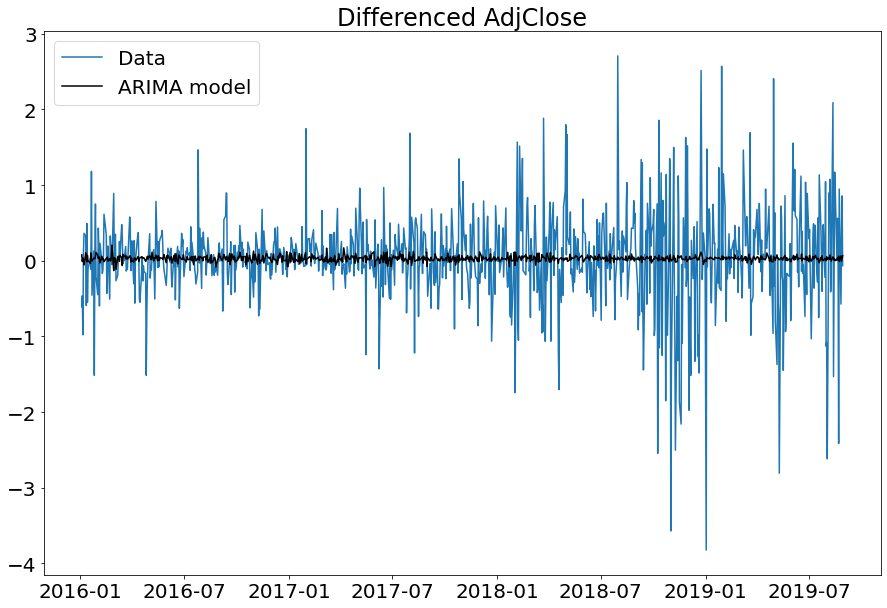

In [193]:
model.plot_fit(figsize=(15,10))

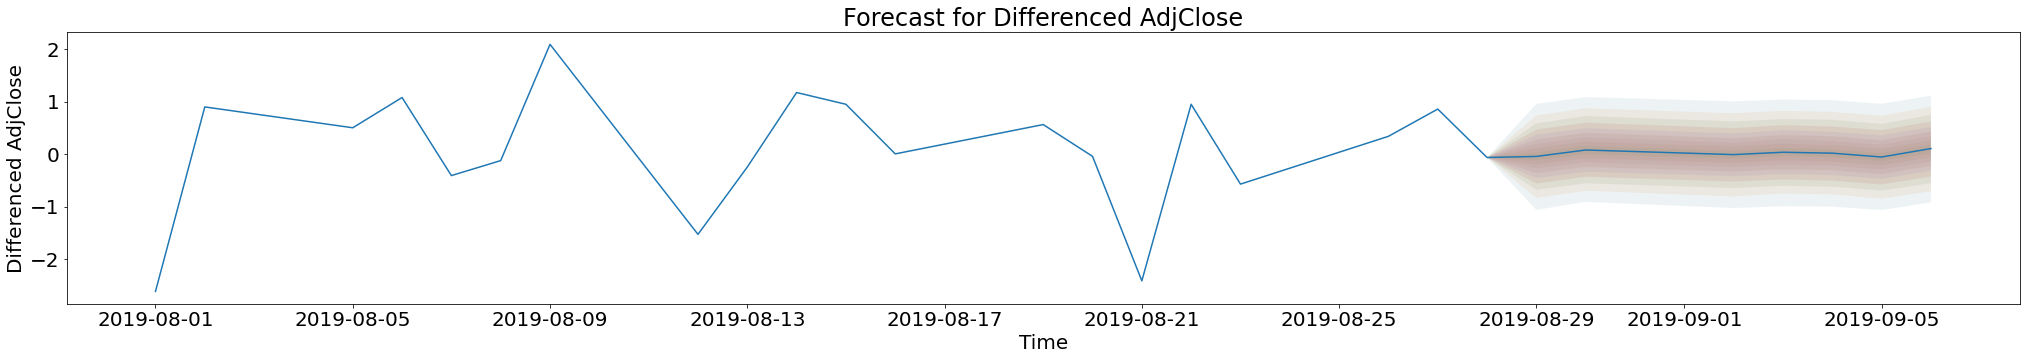

In [170]:
model.plot_predict(h=7, oos_data=appl, figsize=(35,5))

In [171]:
model_est=model.predict(h=7, oos_data=appl,)
model_est

,Differenced AdjClose
Date,
2019-08-29,-0.045876
2019-08-30,0.076733
2019-09-02,-0.011240
2019-09-03,0.033804
2019-09-04,0.016115
2019-09-05,-0.056964
2019-09-06,0.103986


In [172]:
model_est.values

array([[-0.04587579],
       [ 0.07673292],
       [-0.01124013],
       [ 0.03380411],
       [ 0.01611474],
       [-0.0569645 ],
       [ 0.10398643]])

In [173]:
model_est = np.delete(model_est.values, [2])
model_est

array([-0.04587579,  0.07673292,  0.03380411,  0.01611474, -0.0569645 ,
        0.10398643])

In [70]:
futureobs = pd.read_csv("/Users/kundaimariga/Downloads/AAPL-13.csv")

In [60]:
futureobs = futureobs.set_index('Date')

In [61]:
futureobs['AdjClose'] = futureobs['Adj Close']
dif=futureobs['AdjClose'].diff()
dif = dif.replace(np.nan, 0)

In [62]:
dif = pd.DataFrame(dif)

In [63]:
dif

,AdjClose
Date,
2019-08-29,0.000000
2019-08-30,-0.066303
2019-09-03,-0.746639
2019-09-04,0.857155
2019-09-05,1.004524
2019-09-06,-0.004917


In [174]:
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.metrics import r2_score
print('Mean Squared Error:', (mean_squared_error(dif, model_est)))
print('R-squared :', r2_score(dif, model_est))

Mean Squared Error: 0.4129369715759316
R-squared : -0.16644476534171115


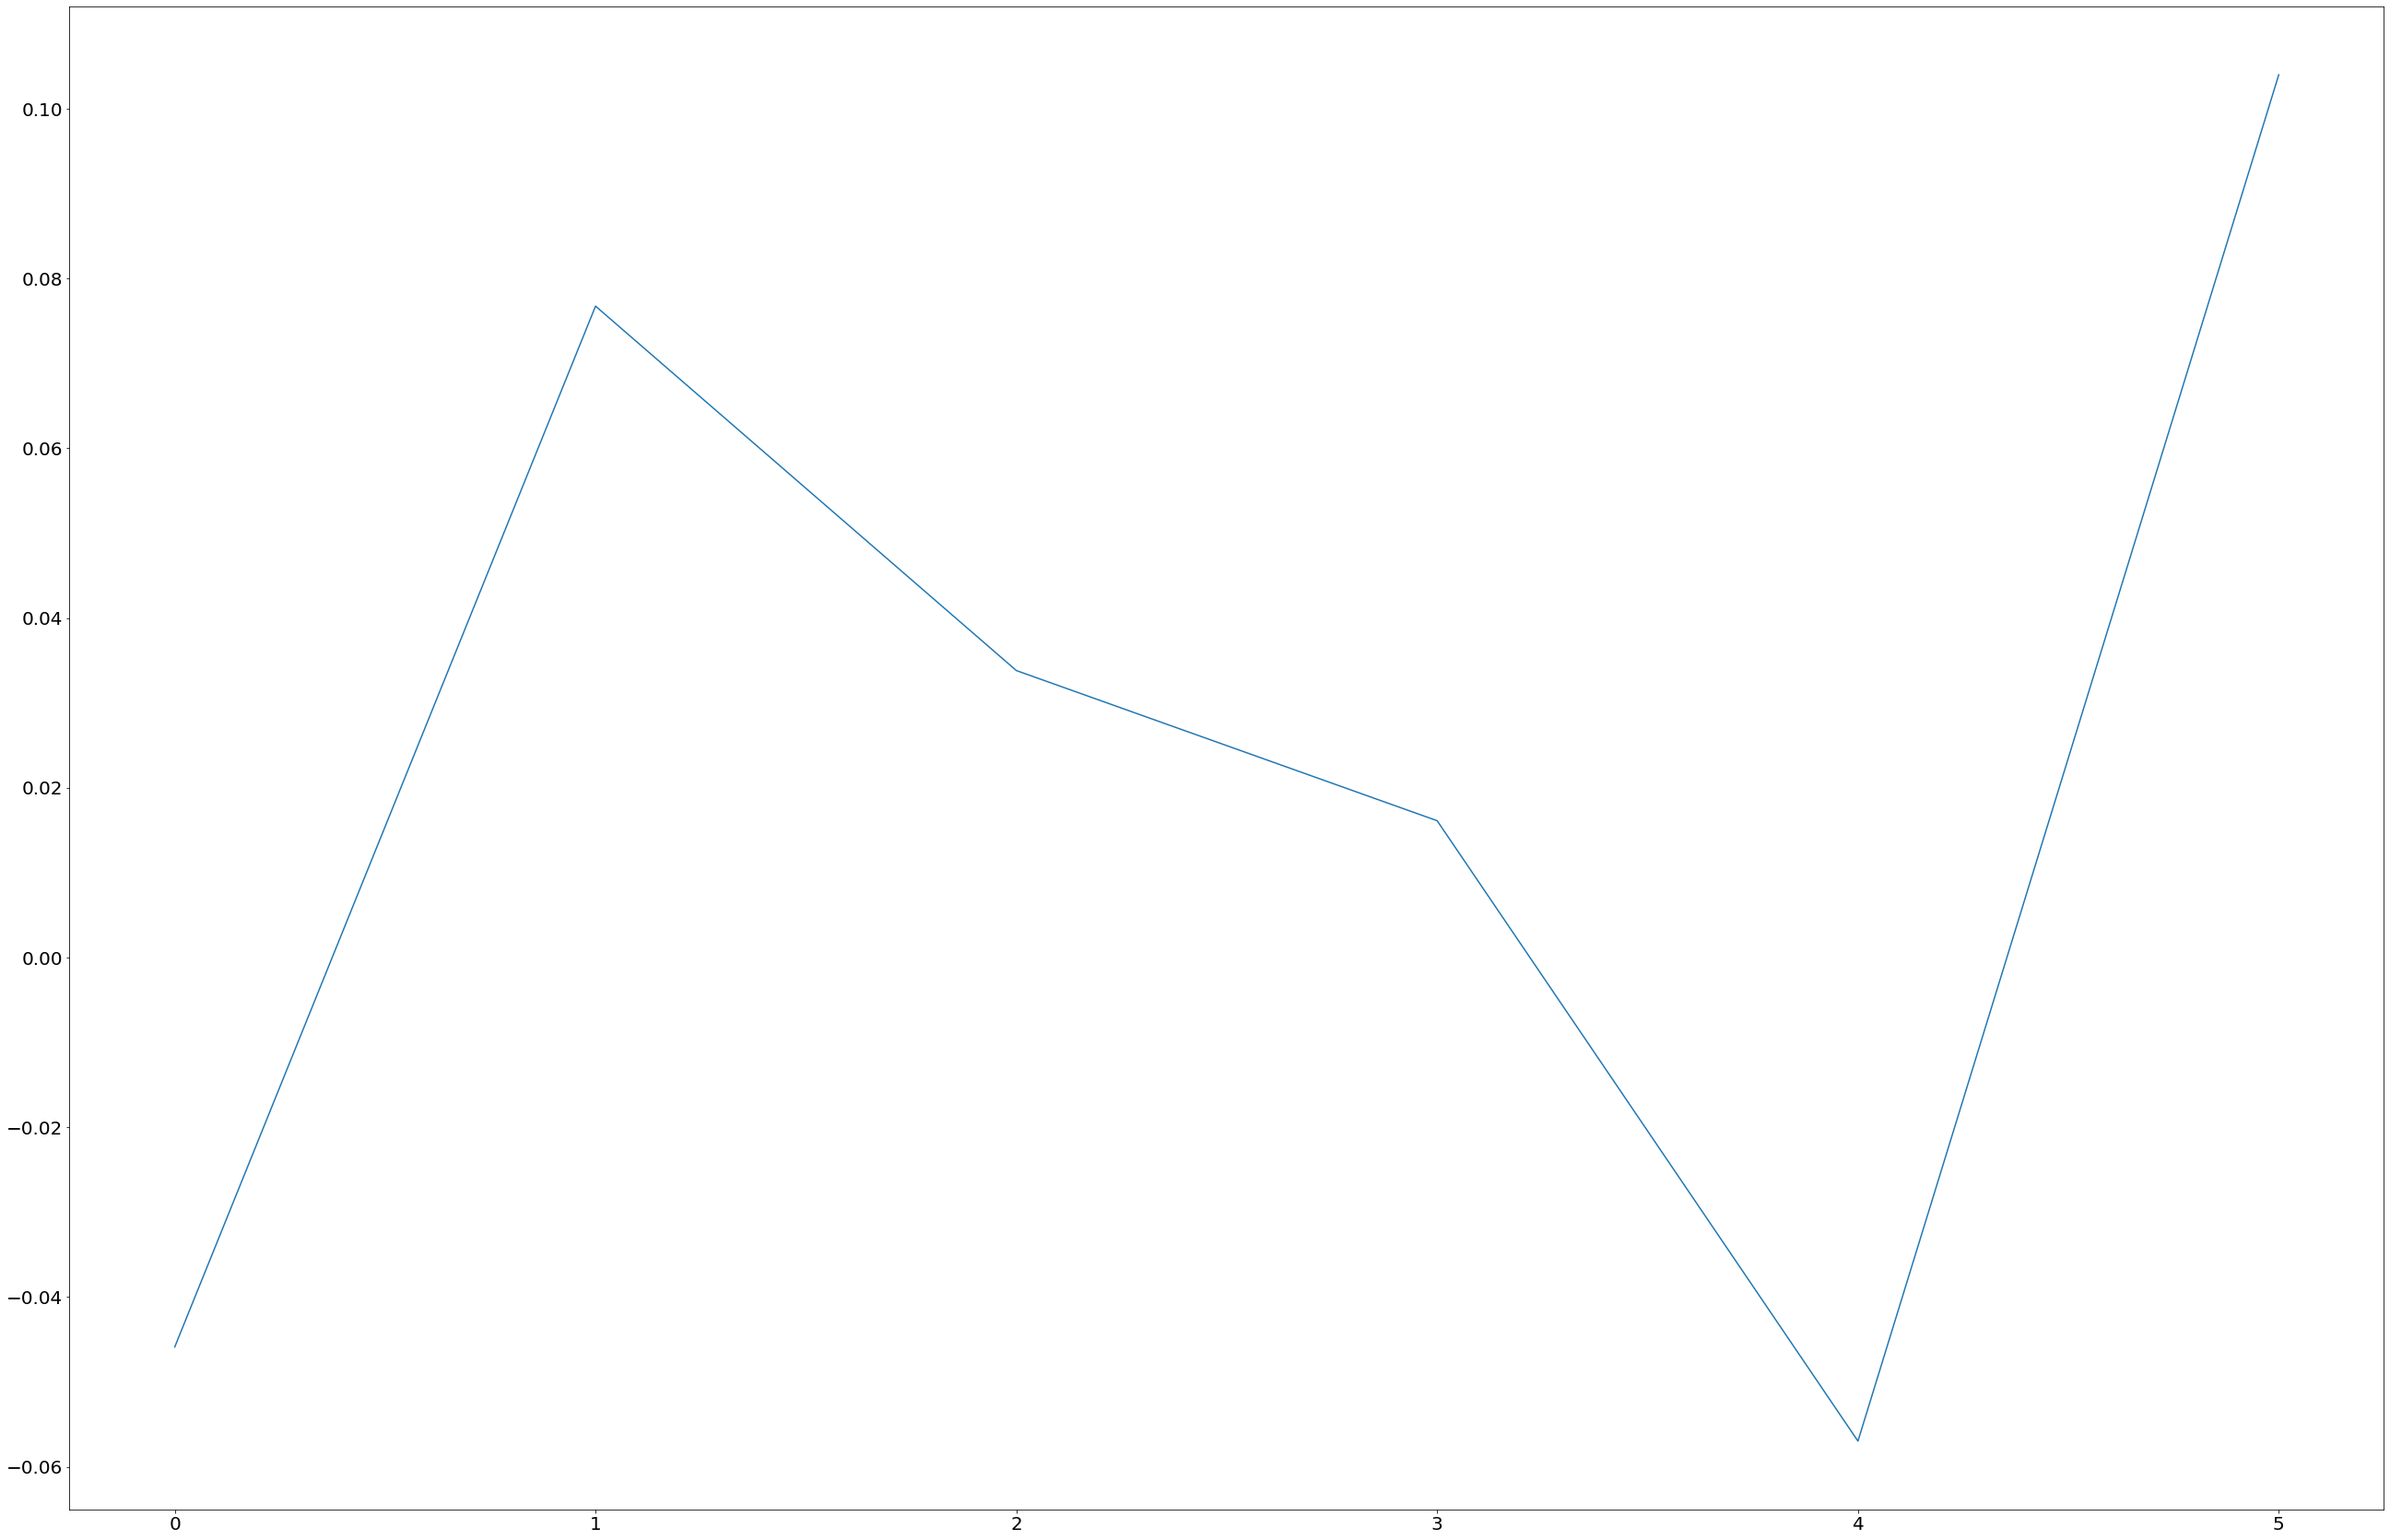

In [176]:
plt.plot(model_est, label = 'forecast')

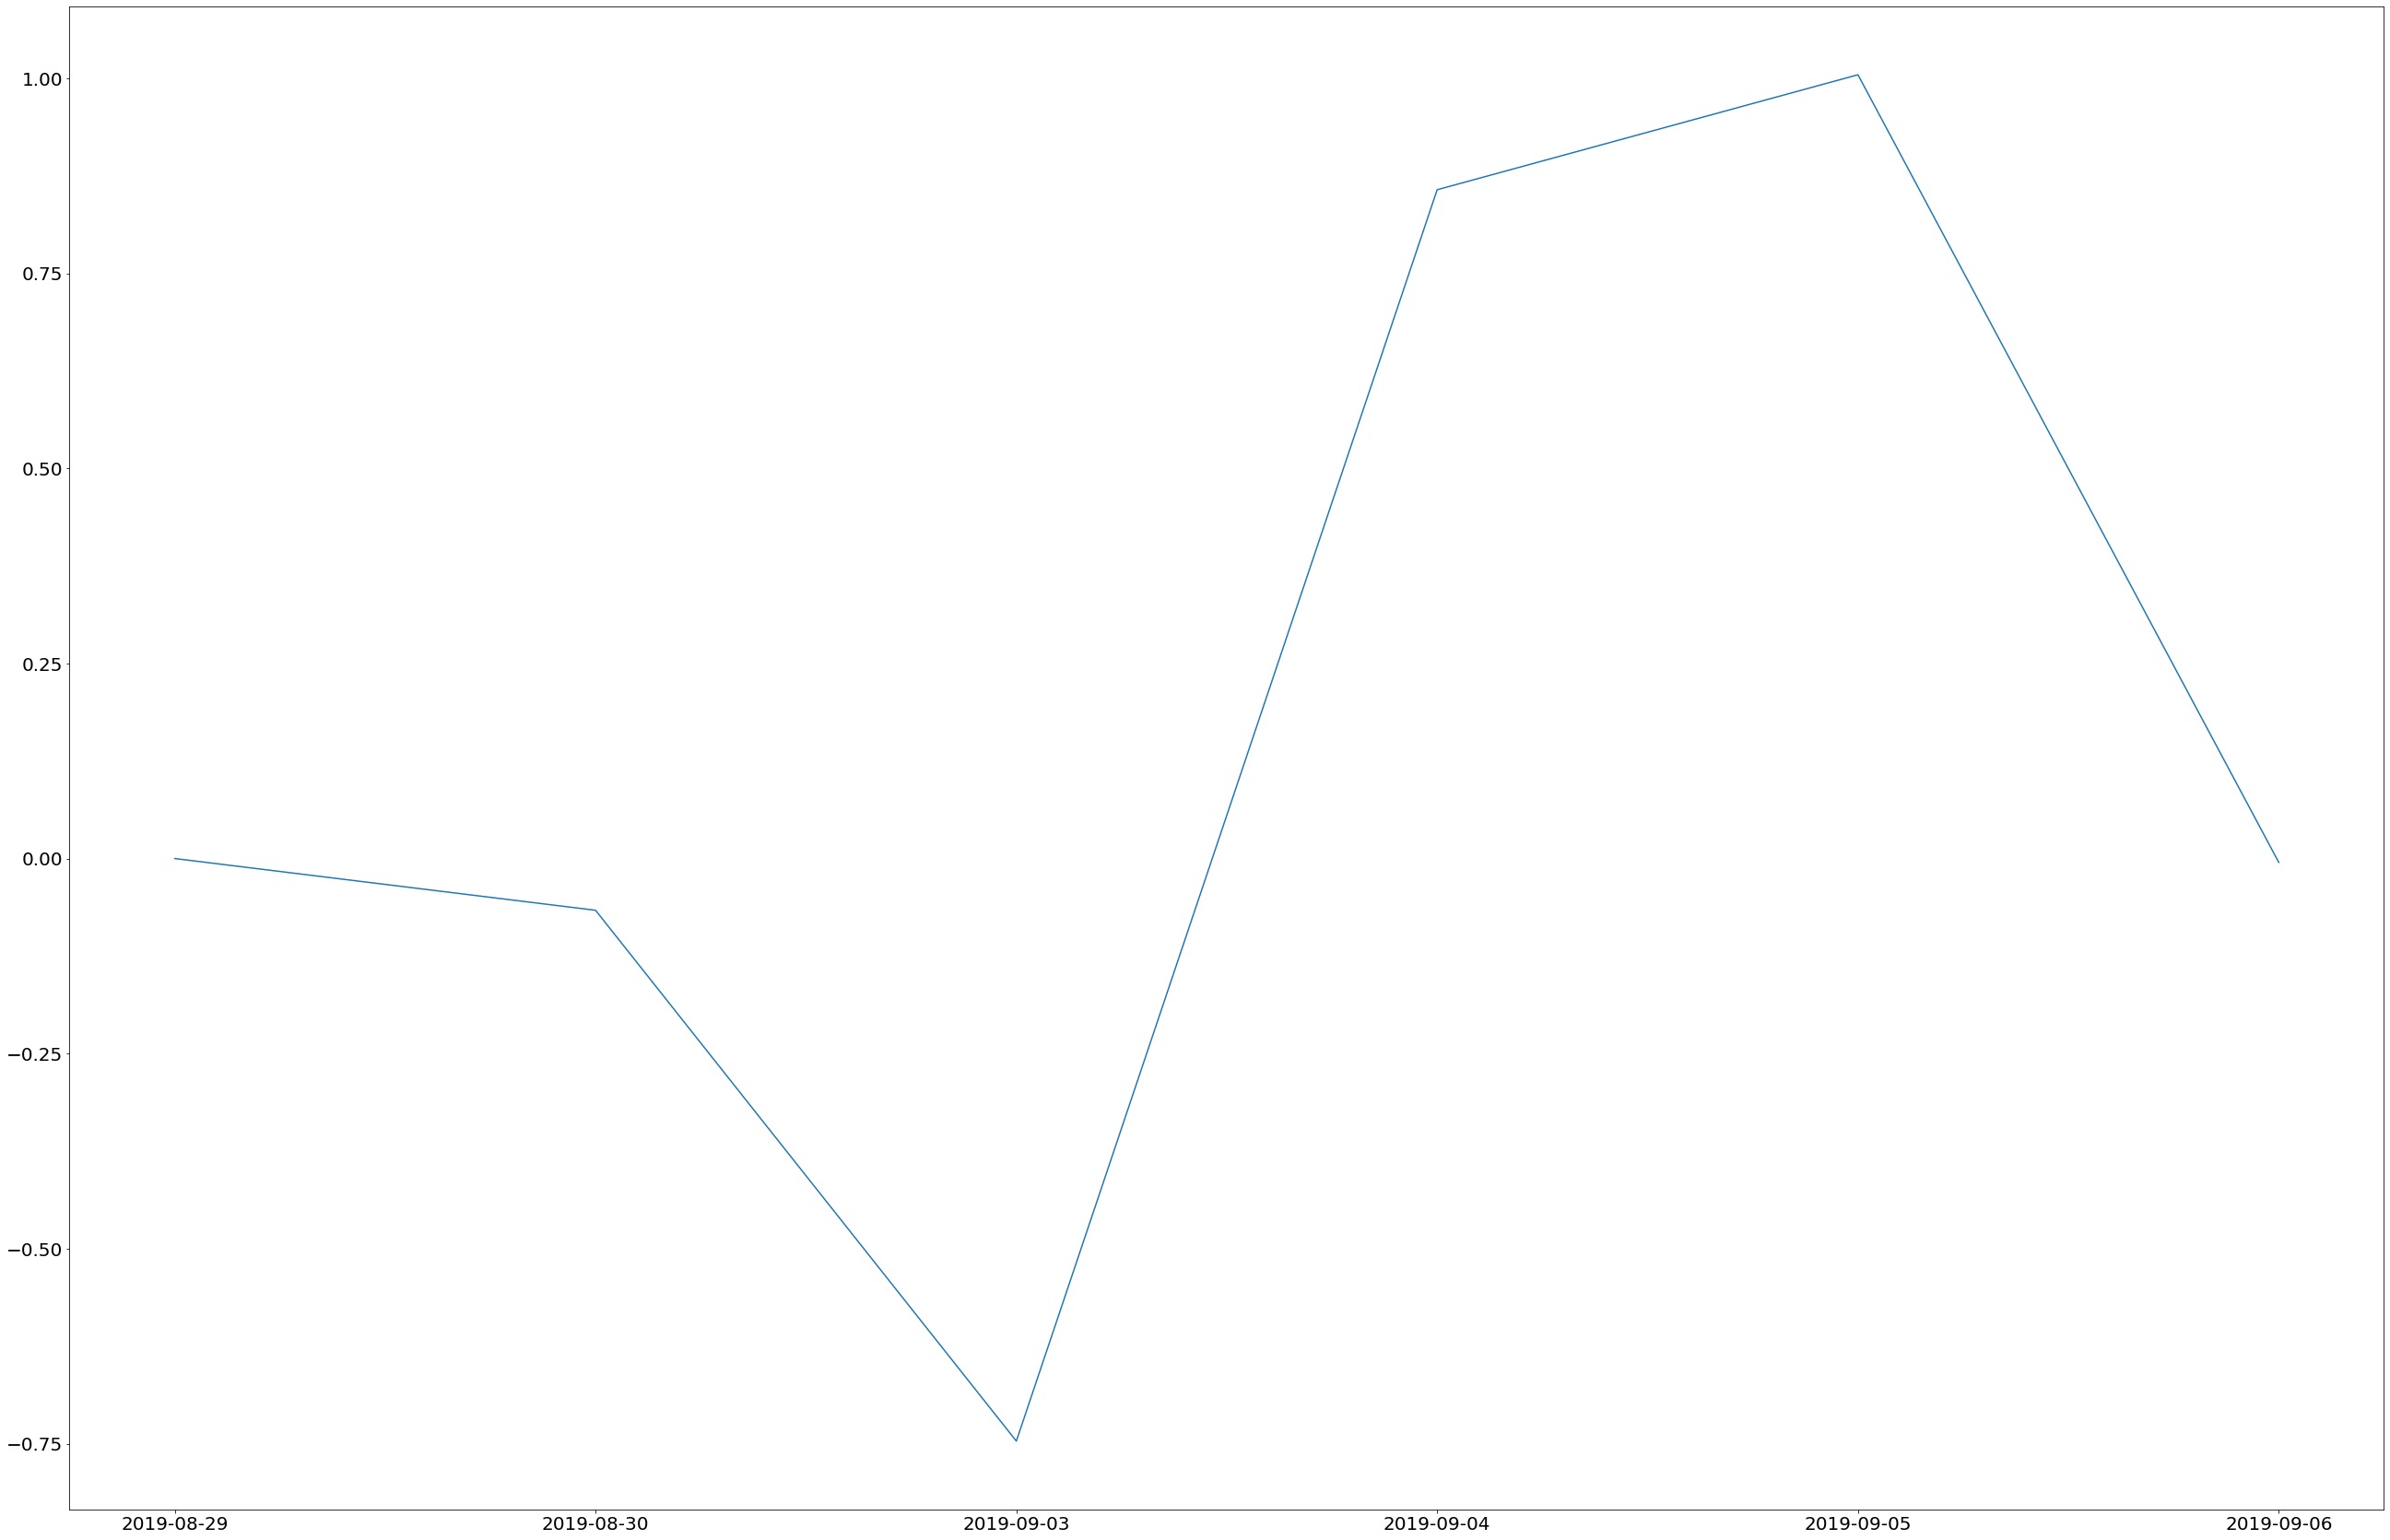

In [67]:
plt.plot(dif, label='actual')

# MODEL 2 - ARIMAX model order (1,1,1)

In [48]:
model2 = pf.ARIMAX(appl, formula='AdjClose~lagpol', ma=1, ar=1, integ=1,
              family=pf.Normal())
x2 = model2.fit("MLE")
x2.summary()

Normal ARIMAX(1,1,1)                                                                                      
======================================================= ==================================================
Dependent Variable: Differenced AdjClose                Method: MLE                                       
Start Date: 2016-01-05 00:00:00                         Log Likelihood: -859.7128                         
End Date: 2019-08-30 00:00:00                           AIC: 1729.4256                                    
Number of observations: 920                             BIC: 1753.5475                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
AR(1)                                    0.4979     0.2577     1.9325   0.0533   (-0.0071 | 1.0029)       
MA(1)                                

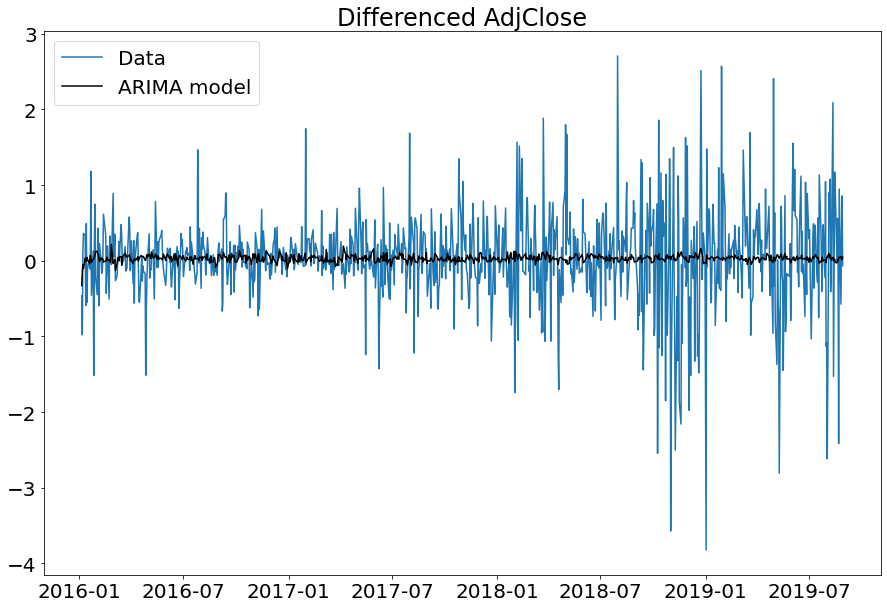

In [49]:
model2.plot_fit(figsize=(15,10))

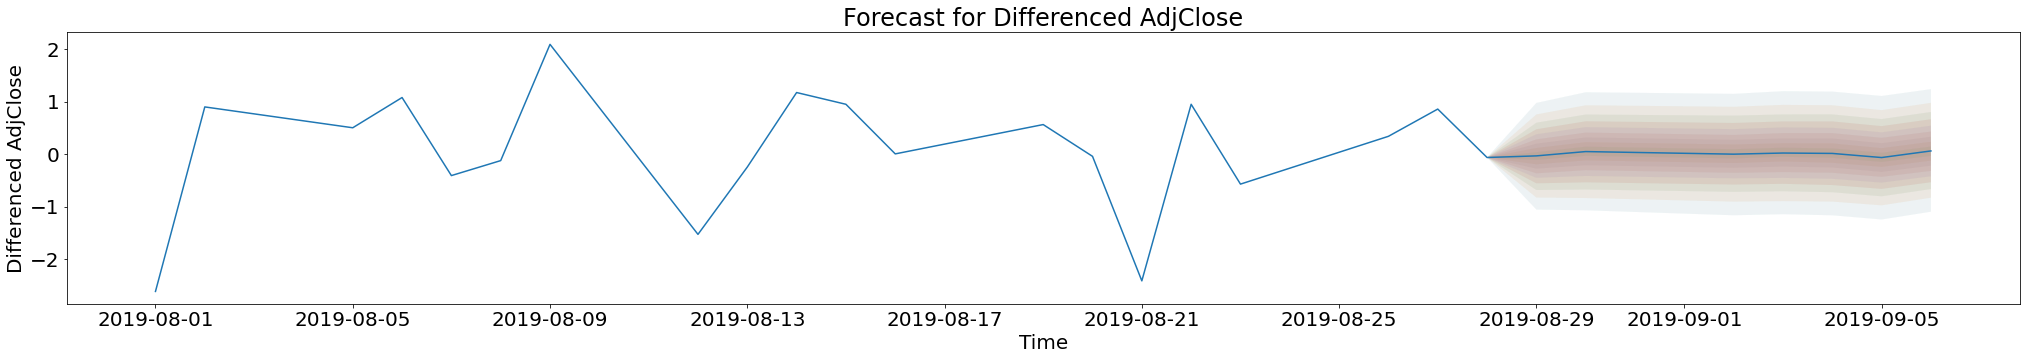

In [50]:
model2.plot_predict(h=7, oos_data=appl, figsize=(35,5))

In [159]:
model2_est=model2.predict(h=7, oos_data=appl,)
model2_est 

,Differenced AdjClose
Date,
2019-08-29,-0.035337
2019-08-30,0.046559
2019-09-02,-0.002803
2019-09-03,0.018772
2019-09-04,0.011390
2019-09-05,-0.067164
2019-09-06,0.058636


In [160]:
model2_est.values

array([[-0.03533704],
       [ 0.04655851],
       [-0.00280287],
       [ 0.01877227],
       [ 0.01139011],
       [-0.06716409],
       [ 0.05863562]])

In [161]:
model2_est = np.delete(model2_est.values, [2])

In [162]:
model2_est

array([-0.03533704,  0.04655851,  0.01877227,  0.01139011, -0.06716409,
        0.05863562])

In [163]:
print('Mean Squared Error:', (mean_squared_error(dif, model2_est)))
print('R-squared :', r2_score(dif, model2_est))

Mean Squared Error: 0.4112855659256774
R-squared : -0.16177995301249948


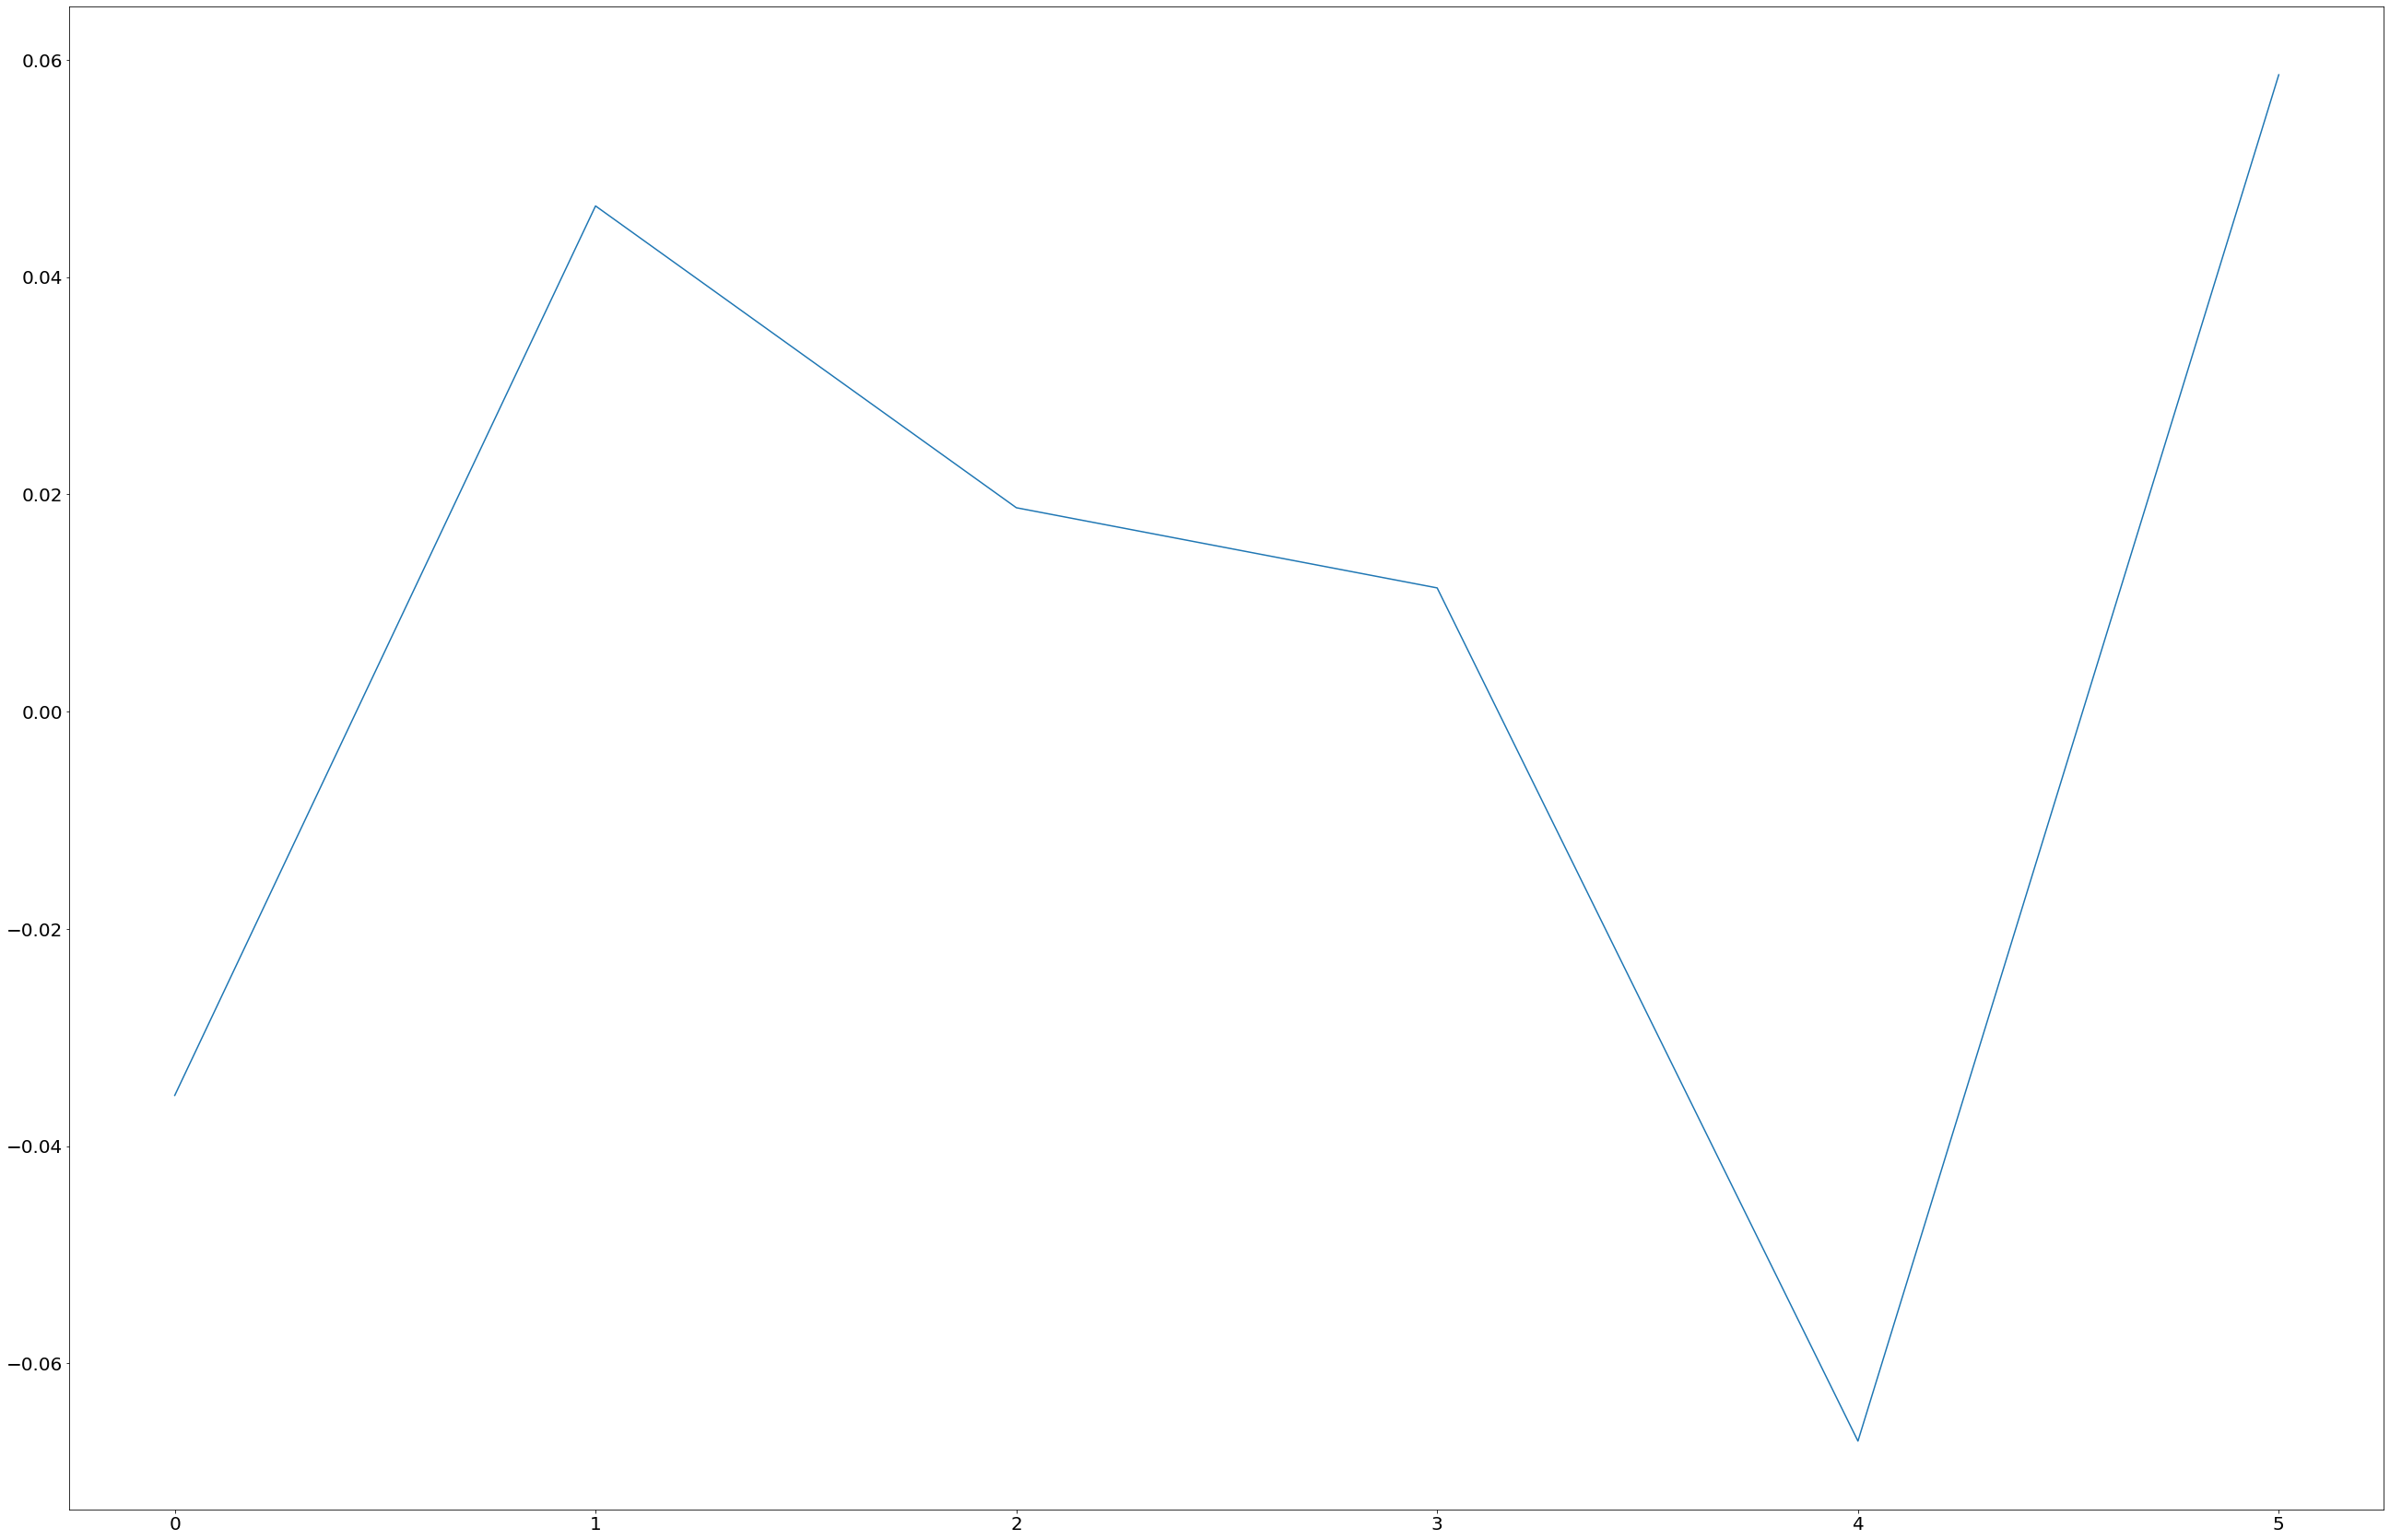

In [165]:
plt.plot(model2_est, label = 'forecast')

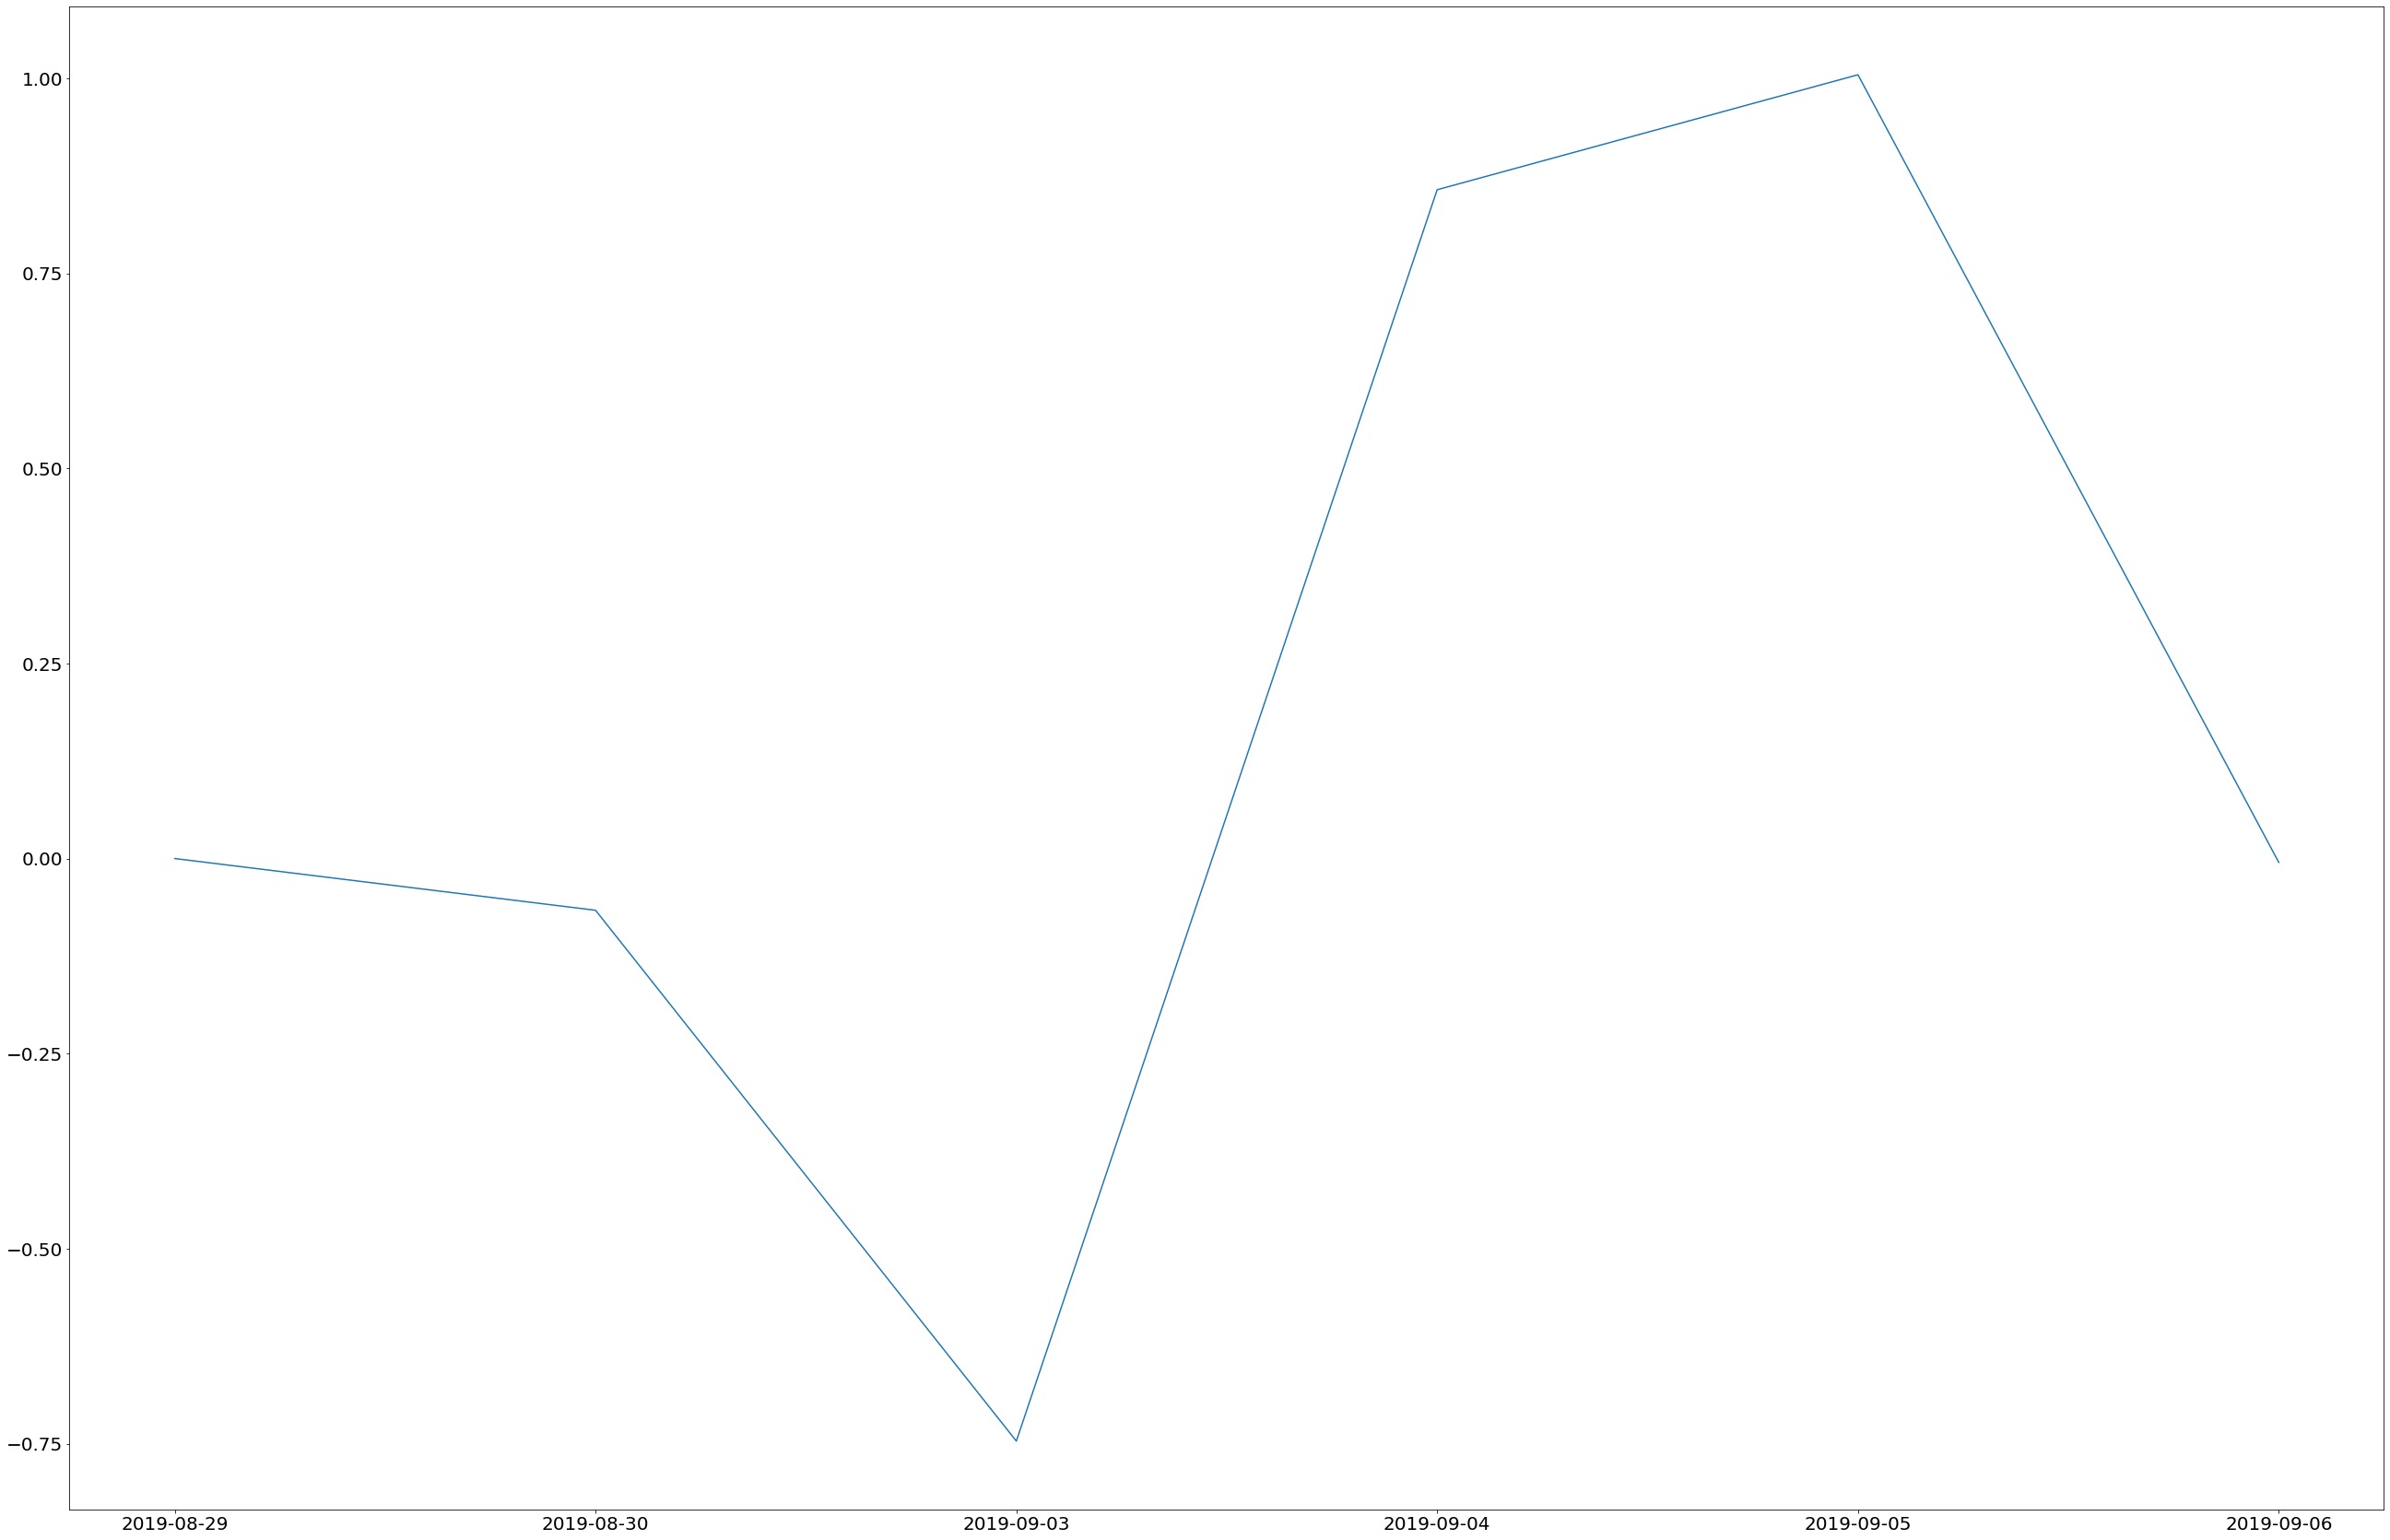

In [144]:
plt.plot(dif, label='actual')

# MODEL 3 - ARIMAX model order (2,1,2)

In [180]:
model3 = pf.ARIMAX(appl, formula='AdjClose~lagpol', ma=2, ar=2, integ=1,
              family=pf.Normal())
x3 = model3.fit("MLE")
x3.summary()

Normal ARIMAX(2,1,2)                                                                                      
======================================================= ==================================================
Dependent Variable: Differenced AdjClose                Method: MLE                                       
Start Date: 2016-01-06 00:00:00                         Log Likelihood: -858.6994                         
End Date: 2019-08-30 00:00:00                           AIC: 1731.3989                                    
Number of observations: 919                             BIC: 1765.1619                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
AR(1)                                    0.1725     0.3106     0.5554   0.5786   (-0.4363 | 0.7813)       
AR(2)                                

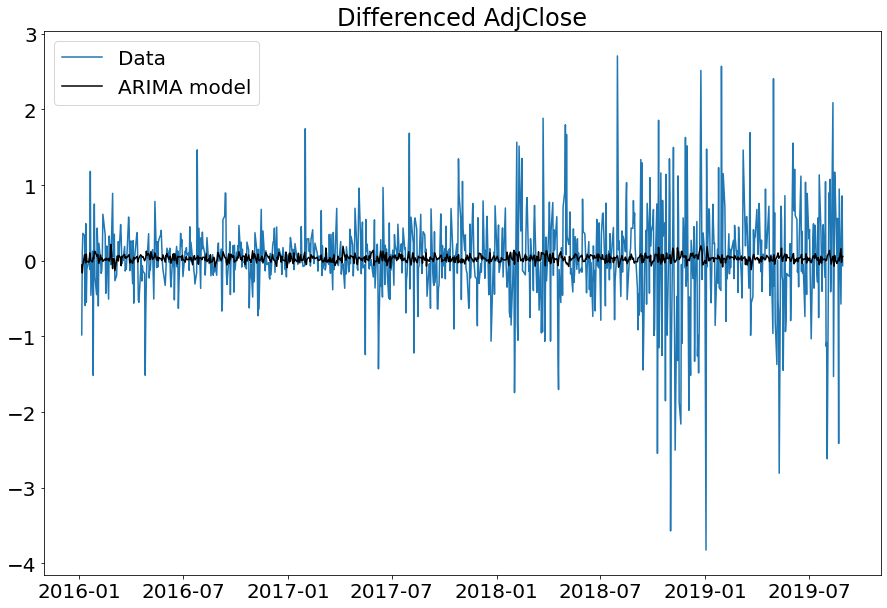

In [181]:
model3.plot_fit(figsize=(15,10))

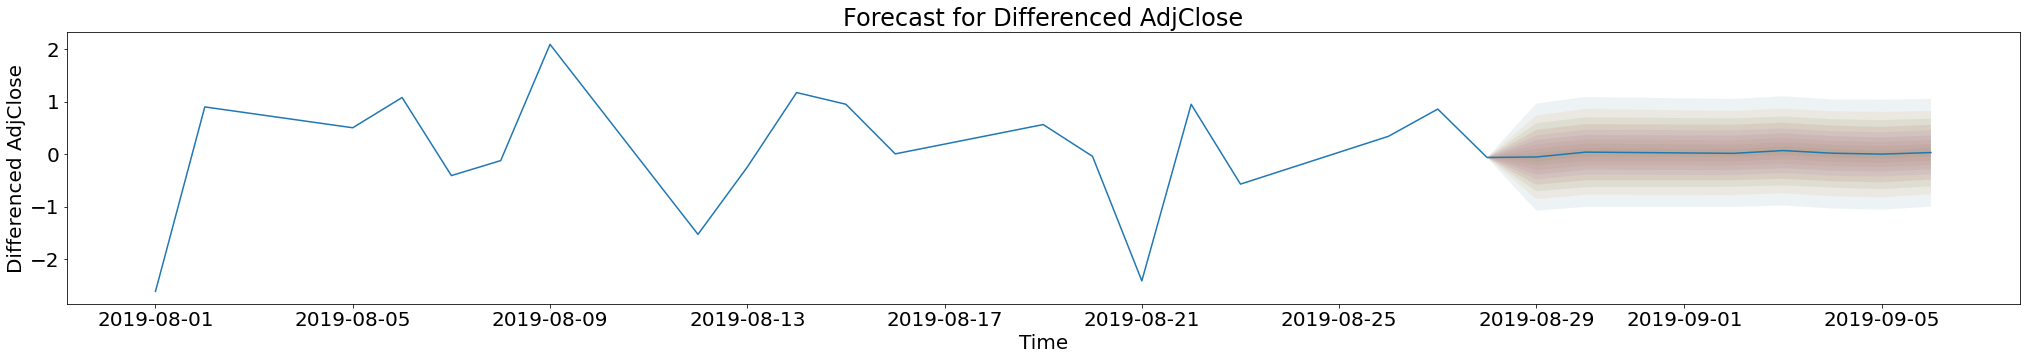

In [182]:
model3.plot_predict(h=7, oos_data=test, figsize=(35,5))

In [183]:
model3_est=model3.predict(h=7, oos_data=appl,)
model3_est 

,Differenced AdjClose
Date,
2019-08-29,-0.075842
2019-08-30,0.067794
2019-09-02,-0.006533
2019-09-03,0.029633
2019-09-04,0.016440
2019-09-05,-0.062404
2019-09-06,0.093347


In [184]:
model3_est.values

array([[-0.07584217],
       [ 0.06779405],
       [-0.00653286],
       [ 0.02963259],
       [ 0.01643992],
       [-0.06240447],
       [ 0.09334735]])

In [185]:
model3_est = np.delete(model3_est.values, [2])

In [186]:
model3_est

array([-0.07584217,  0.06779405,  0.02963259,  0.01643992, -0.06240447,
        0.09334735])

In [187]:
print('Mean Squared Error:', (mean_squared_error(dif, model3_est)))
print('R-squared :', r2_score(dif, model3_est))

Mean Squared Error: 0.4135209568475535
R-squared : -0.16809437922956527


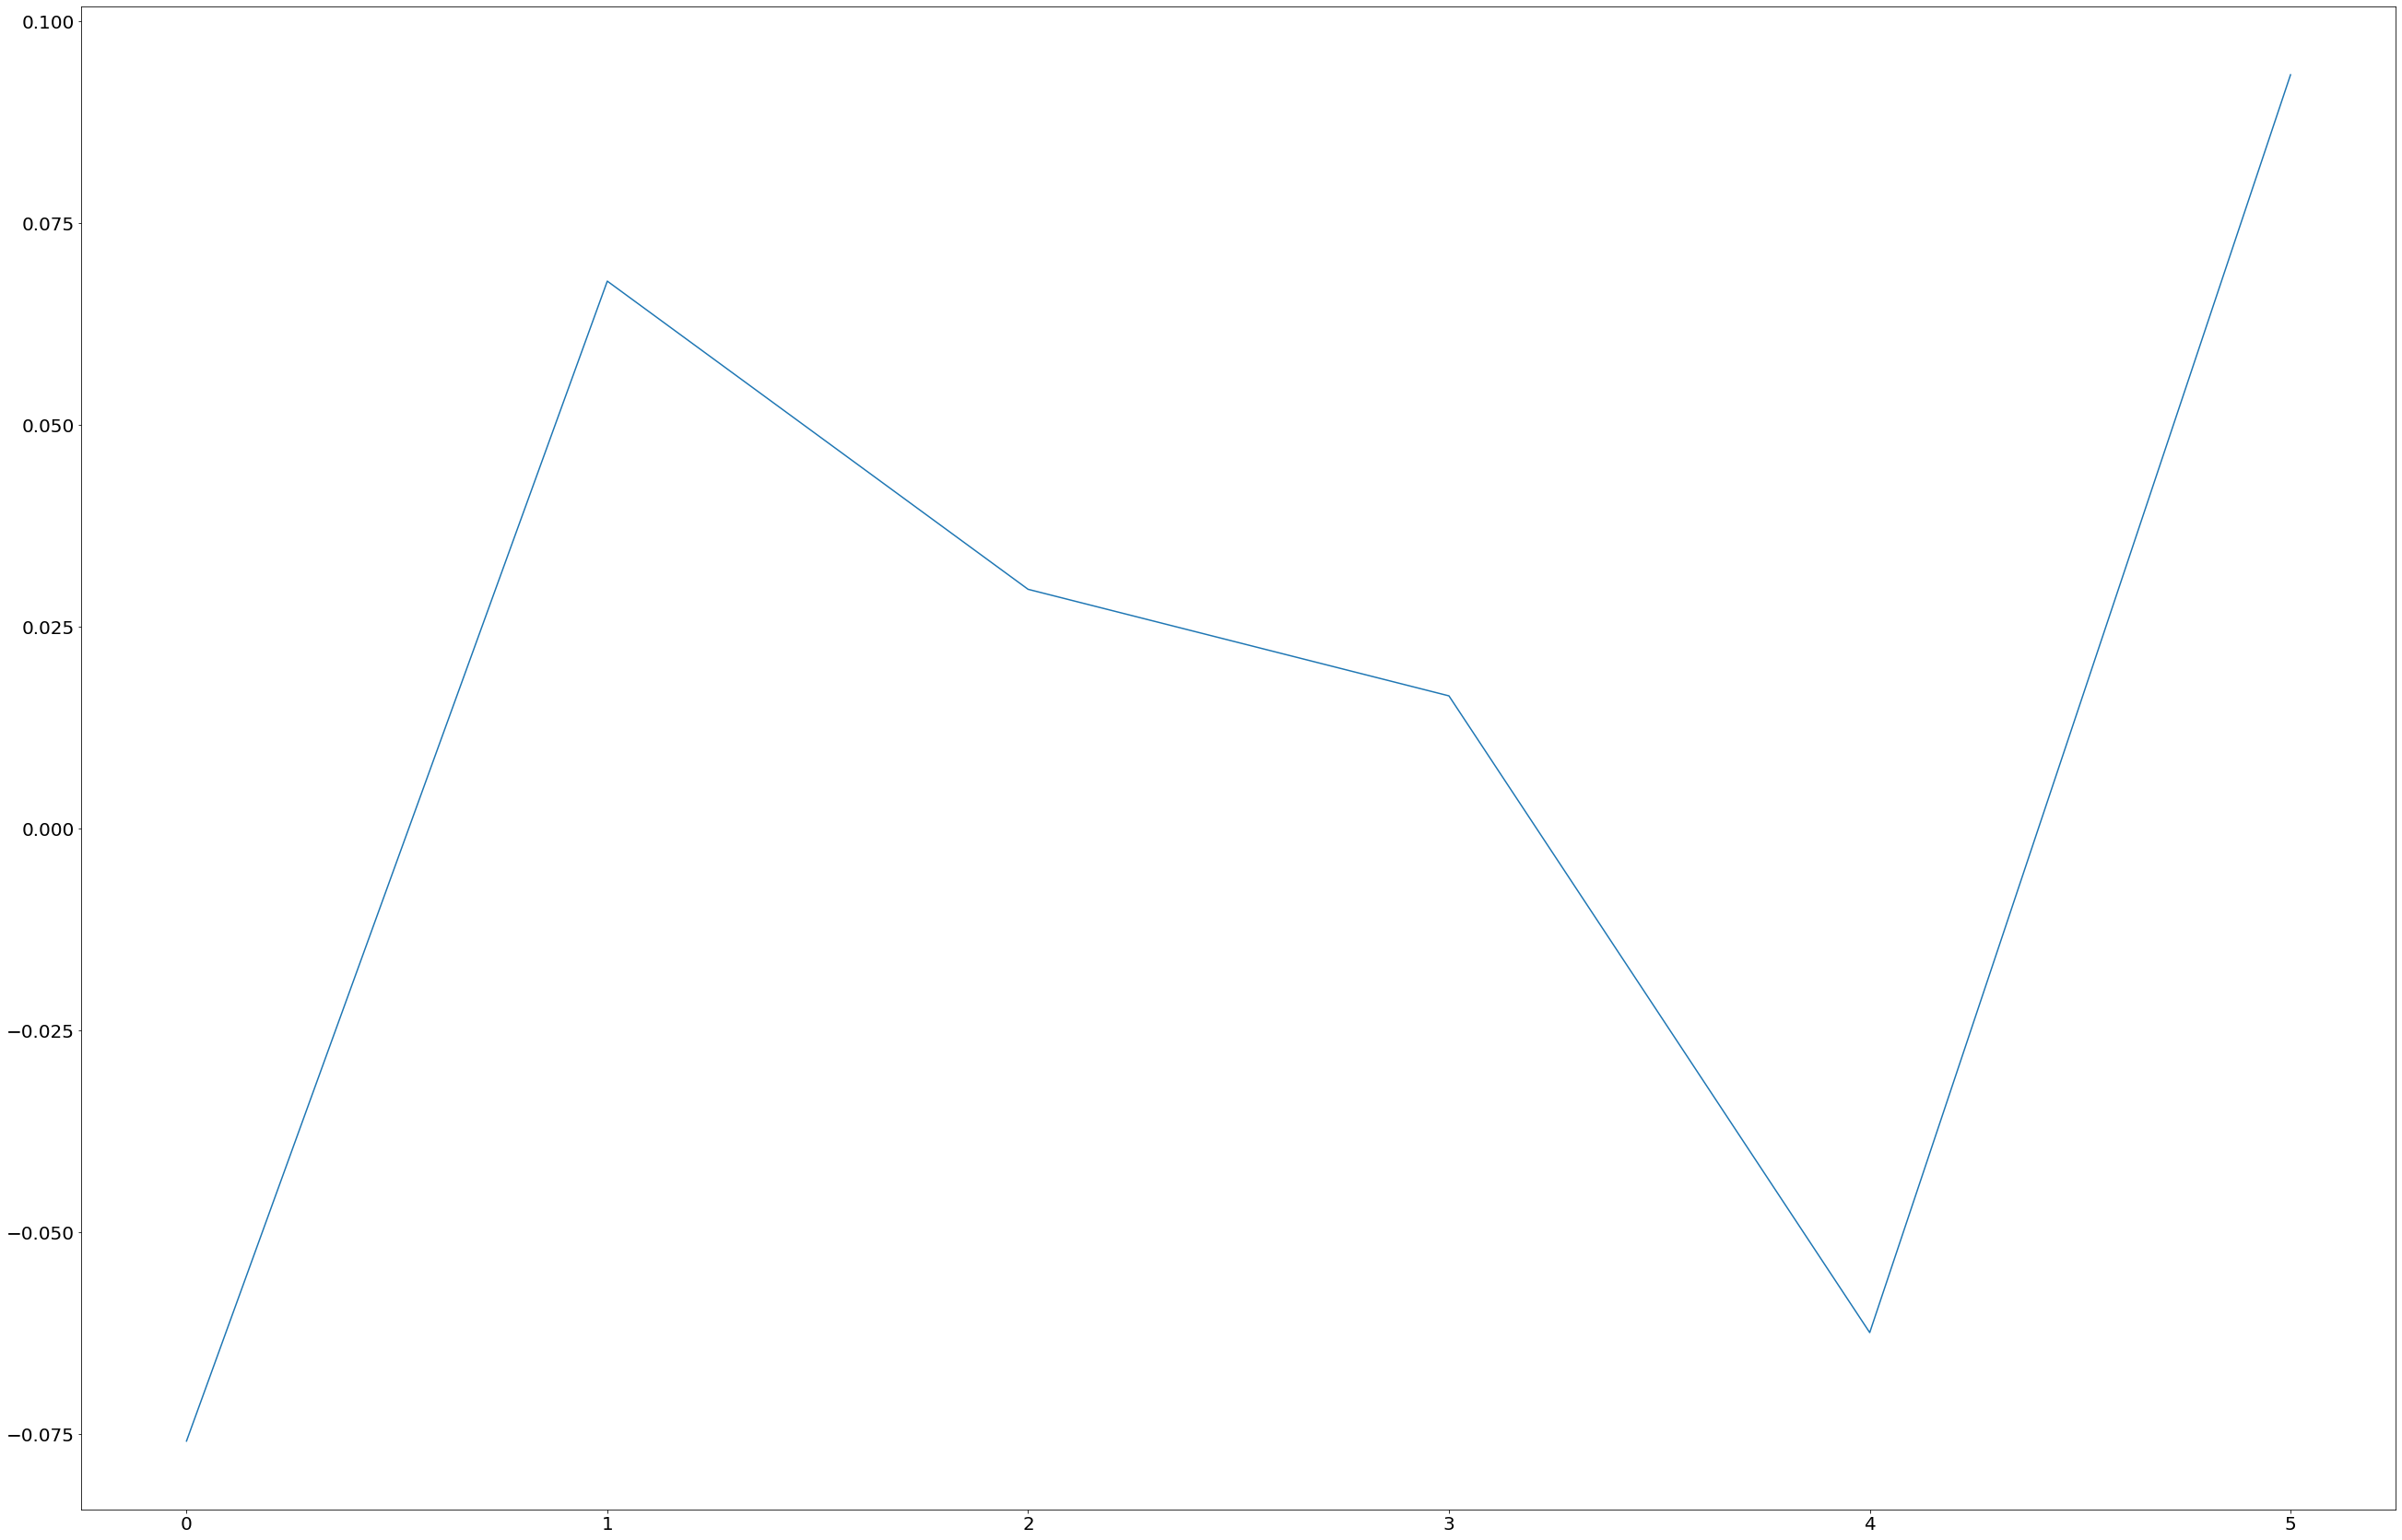

In [188]:
plt.plot(model3_est, label = 'forecast')